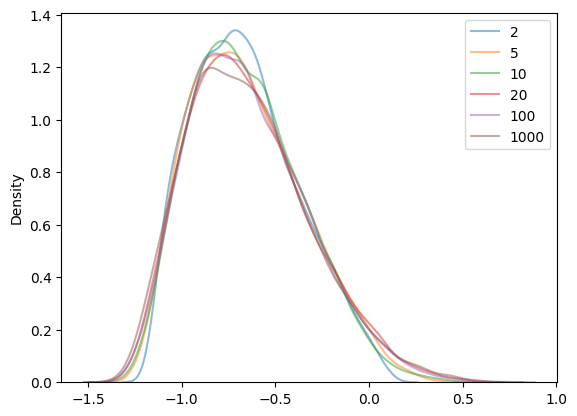

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

N = 10000
alpha = np.random.randn()
beta = np.random.randn(1000)
for p in [2,5,10,20,100,1000]:
    X = np.random.rand(N*p).reshape((N,p))
    # eta = X.dot(beta[:p]) + alpha
    eta = 2*(X-0.5).dot(beta[:p])/np.sqrt(p) + alpha
    k = 4
    z = 3 * stats.logistic.cdf(eta) - 1.5
    sns.kdeplot(z, alpha=0.5, label=p)
plt.legend();

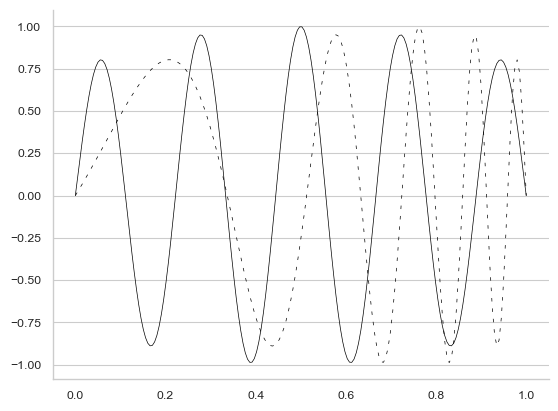

In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

np.random.seed(43)

N = 10000
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

t = np.linspace(0,1,1000)
def m(x):
    eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
    k = 4
    a = 3 * stats.logistic.cdf(eta) - 1.5
    gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)
    # return gam_t

# for i in range(15):
#     sns.lineplot(x=t, y=m(np.random.randn(p)), color='black', alpha=1, linewidth=0.5)

t = np.linspace(0,1,200)
template = (1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t)
plt.plot(t, template, color='black', linewidth=0.5)

plt.plot(t, m(np.random.rand(p)), color='black', linestyle=(0, (5, 10)), linewidth=0.5)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.grid(axis='x')
plt.savefig('plots/sample_phase.pdf')

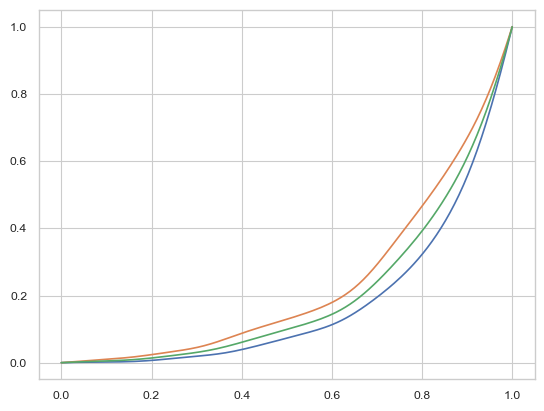

In [250]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product




N = 2
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

x, y, mx = gen_data(N,p,alpha,beta)

fig = skfda.FDataGrid(y.data, y.M.grid).plot();
skfda.FDataGrid(y.frechet_mean(), y.M.grid).plot(fig=fig);


[1.00000606]
[1.00000537]


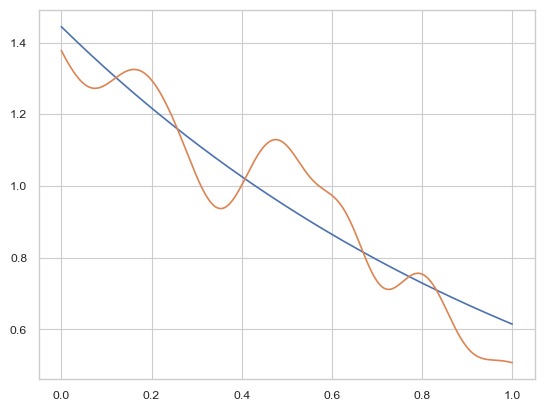

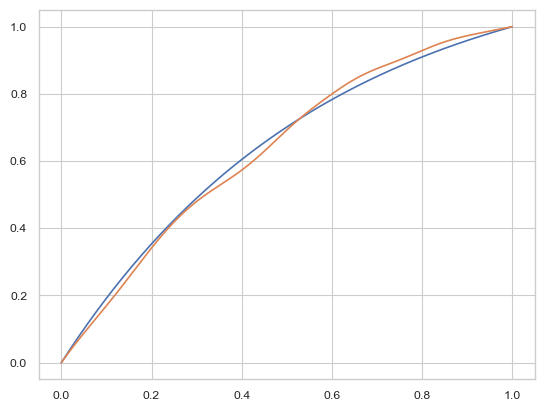

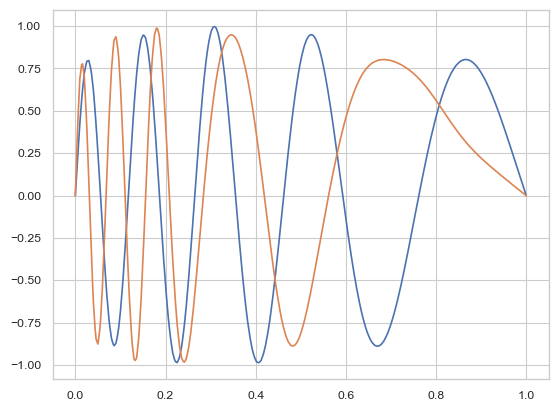

In [229]:
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

# np.random.seed(5)
template = skfda.FDataGrid((1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t), t)

mx = m(np.random.randn(p))

eps = 0.1
t = np.linspace(0,1,200)

x = np.random.randn(p)
eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
k = 4
a = 3 * stats.logistic.cdf(eta) - 1.5
gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
mx = (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)

y = skfda.FDataGrid(mx, t)
gam_y = skfda.FDataGrid(gam_t, t)


srsf = SRSF()
psi = srsf.fit_transform(gam_y)

v = skfda.FDataGrid(gp(t, kernel), t)
vx = v - inner_product(psi, v) * psi
nvx = skfda.misc.metrics.LpNorm(2)(vx)

psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
gam_pv = srsf.inverse_transform(psi_pv)

y_pv = y.compose(gam_pv)

print(skfda.misc.metrics.LpNorm(2)(psi))
print(skfda.misc.metrics.LpNorm(2)(psi_pv))

# template.plot();
# y.plot();
# plt.plot(t, gam_t);
# y.plot()
# q.plot()

fig=psi.plot()
psi_pv.plot(fig=fig)

fig=gam_y.plot()
gam_pv.plot(fig=fig);

fig=y.plot()
y_pv.plot(fig=fig);

# qpv.plot();

# skfda.misc.metrics.LpNorm(2)(q)

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

OUT_FILE = 'results/20230621_result_phase_400.json'

def gen_data(N, p, alpha, beta):
    M = FisherRaoPhase(np.linspace(0,1,100))
    t = M.grid

    def m(x):
        eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
        k = 4
        a = 3 * stats.logistic.cdf(eta) - 1.5
        return (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    
    def add_noise(gam, eps = 0.1):
        k = lambda x1, x2: np.exp(-100 * np.subtract.outer(x1, x2)**2)
        gp = lambda t: np.random.multivariate_normal(mean=np.zeros(len(t)), cov=k(t,t))
        
        # map to psi = srsf of gamma which lies on the sphere
        srsf = SRSF()
        gam = skfda.FDataGrid(gam, t)
        psi = srsf.fit_transform(gam)

        # sample a random tangent vector
        v = skfda.FDataGrid(gp(t), t)
        vx = v - inner_product(psi, v) * psi
        nvx = skfda.misc.metrics.LpNorm(2)(vx)

        # apply it to psi and transform back to gamma space
        psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
        return srsf.inverse_transform(psi_pv).data_matrix[0,...,0]

    x = np.random.rand(N*p).reshape((N,p))
    mx = np.array([ m(x[i,:]) for i in range(N)])
    y = np.array([ add_noise(mx[i,:]) for i in range(N)])
    return x, MetricData(M, y), MetricData(M, mx)

bench(
    gen_data,
    OUT_FILE,
    ps=[2, 5, 10, 20],
    Ns=[400],
    replicas=100
)

INFO: Using numpy backend
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/pyt

[2023-06-21 12:17:36.258885] Progress: N=400	p=2	i=0
[2023-06-21 12:17:40.634848] Distances for cart_2means
[2023-06-21 12:17:40.634979] dt = 0
[2023-06-21 12:17:40.634999] Fitting for cart_2means
[2023-06-21 12:18:09.102174] dt = 28.46732497215271
[2023-06-21 12:18:09.102246] MSE for cart_2means
[2023-06-21 12:18:11.711228] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will b

[2023-06-21 12:18:15.794848] dt = 4.083546876907349
[2023-06-21 12:18:15.794892] Fitting for medoid_greedy
[2023-06-21 12:18:16.277494] dt = 0.48271822929382324
[2023-06-21 12:18:16.277791] MSE for medoid_greedy
[2023-06-21 12:18:18.578466] Progress: N=400	p=2	i=1
[2023-06-21 12:18:23.896266] Distances for cart_2means
[2023-06-21 12:18:23.896430] dt = 0
[2023-06-21 12:18:23.896448] Fitting for cart_2means
[2023-06-21 12:18:50.827818] dt = 26.93155312538147
[2023-06-21 12:18:50.827900] MSE for cart_2means
[2023-06-21 12:18:53.965466] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 12:18:55.882867] dt = 1.917330026626587
[2023-06-21 12:18:55.882906] Fitting for medoid_greedy
[2023-06-21 12:18:56.324401] dt = 0.4416038990020752
[2023-06-21 12:18:56.326135] MSE for medoid_greedy
[2023-06-21 12:18:59.093642] Progress: N=400	p=2	i=2
[2023-06-21 12:19:03.365073] Distances for cart_2means
[2023-06-21 12:19:03.366337] dt = 0
[2023-06-21 12:19:03.366363] Fitting for cart_2means
[2023-06-21 12:19:34.404954] dt = 31.039880990982056
[2023-06-21 12:19:34.405044] MSE for cart_2means
[2023-06-21 12:19:37.509394] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 12:19:39.459438] dt = 1.9499719142913818
[2023-06-21 12:19:39.459497] Fitting for medoid_greedy
[2023-06-21 12:19:39.927024] dt = 0.46765613555908203
[2023-06-21 12:19:39.927247] MSE for medoid_greedy
[2023-06-21 12:19:42.716037] Progress: N=400	p=2	i=3
[2023-06-21 12:19:47.854130] Distances for cart_2means
[2023-06-21 12:19:47.854220] dt = 0
[2023-06-21 12:19:47.854226] Fitting for cart_2means
[2023-06-21 12:20:20.713403] dt = 32.859272956848145
[2023-06-21 12:20:20.713492] MSE for cart_2means
[2023-06-21 12:20:23.578643] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 12:20:25.685967] dt = 2.1072511672973633
[2023-06-21 12:20:25.686007] Fitting for medoid_greedy
[2023-06-21 12:20:26.347847] dt = 0.661949872970581
[2023-06-21 12:20:26.348016] MSE for medoid_greedy
[2023-06-21 12:20:29.002732] Progress: N=400	p=2	i=4
[2023-06-21 12:20:33.873482] Distances for cart_2means
[2023-06-21 12:20:33.873561] dt = 0
[2023-06-21 12:20:33.873567] Fitting for cart_2means
[2023-06-21 12:21:04.356228] dt = 30.482746124267578
[2023-06-21 12:21:04.356311] MSE for cart_2means
[2023-06-21 12:21:07.506809] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 12:21:09.556442] dt = 2.0495481491088867
[2023-06-21 12:21:09.556475] Fitting for medoid_greedy
[2023-06-21 12:21:10.136028] dt = 0.5796678066253662
[2023-06-21 12:21:10.136159] MSE for medoid_greedy
[2023-06-21 12:21:12.573353] Progress: N=400	p=2	i=5
[2023-06-21 12:21:17.164991] Distances for cart_2means
[2023-06-21 12:21:17.165076] dt = 0
[2023-06-21 12:21:17.165082] Fitting for cart_2means
[2023-06-21 12:21:48.151767] dt = 30.986776113510132
[2023-06-21 12:21:48.151847] MSE for cart_2means
[2023-06-21 12:21:51.412793] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 12:21:53.320507] dt = 1.9076430797576904
[2023-06-21 12:21:53.320539] Fitting for medoid_greedy
[2023-06-21 12:21:53.970692] dt = 0.650256872177124
[2023-06-21 12:21:53.971569] MSE for medoid_greedy
[2023-06-21 12:21:56.816408] Progress: N=400	p=2	i=6
[2023-06-21 12:22:01.313493] Distances for cart_2means
[2023-06-21 12:22:01.313785] dt = 0
[2023-06-21 12:22:01.313811] Fitting for cart_2means
[2023-06-21 12:22:34.314680] dt = 33.001184940338135
[2023-06-21 12:22:34.314788] MSE for cart_2means
[2023-06-21 12:22:36.818456] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 12:22:38.814068] dt = 1.995542049407959
[2023-06-21 12:22:38.814102] Fitting for medoid_greedy
[2023-06-21 12:22:39.303085] dt = 0.4890859127044678
[2023-06-21 12:22:39.303614] MSE for medoid_greedy
[2023-06-21 12:22:41.877020] Progress: N=400	p=2	i=7
[2023-06-21 12:22:46.235116] Distances for cart_2means
[2023-06-21 12:22:46.236219] dt = 0
[2023-06-21 12:22:46.236225] Fitting for cart_2means
[2023-06-21 12:23:18.807522] dt = 32.57240605354309
[2023-06-21 12:23:18.807614] MSE for cart_2means
[2023-06-21 12:23:21.580843] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 12:23:23.773325] dt = 2.19240403175354
[2023-06-21 12:23:23.773360] Fitting for medoid_greedy
[2023-06-21 12:23:24.206346] dt = 0.43309783935546875
[2023-06-21 12:23:24.206546] MSE for medoid_greedy
[2023-06-21 12:23:26.828753] Progress: N=400	p=2	i=8
[2023-06-21 12:23:31.958803] Distances for cart_2means
[2023-06-21 12:23:31.958990] dt = 0
[2023-06-21 12:23:31.959004] Fitting for cart_2means
[2023-06-21 12:24:05.324206] dt = 33.36540412902832
[2023-06-21 12:24:05.324287] MSE for cart_2means
[2023-06-21 12:24:08.213541] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 12:24:10.358015] dt = 2.144404888153076
[2023-06-21 12:24:10.358064] Fitting for medoid_greedy
[2023-06-21 12:24:10.884234] dt = 0.5262858867645264
[2023-06-21 12:24:10.884620] MSE for medoid_greedy
[2023-06-21 12:24:13.973931] Progress: N=400	p=2	i=9
[2023-06-21 12:24:18.728237] Distances for cart_2means
[2023-06-21 12:24:18.730509] dt = 0
[2023-06-21 12:24:18.730519] Fitting for cart_2means
[2023-06-21 12:24:51.340862] dt = 32.61262488365173
[2023-06-21 12:24:51.340952] MSE for cart_2means
[2023-06-21 12:24:54.080468] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-21 12:24:56.925471] dt = 2.844928026199341
[2023-06-21 12:24:56.925535] Fitting for medoid_greedy
[2023-06-21 12:24:57.479322] dt = 0.5539219379425049
[2023-06-21 12:24:57.480339] MSE for medoid_greedy
[2023-06-21 12:25:00.216867] Progress: N=400	p=2	i=10
[2023-06-21 12:25:06.106591] Distances for cart_2means
[2023-06-21 12:25:06.106742] dt = 0
[2023-06-21 12:25:06.106752] Fitting for cart_2means
[2023-06-21 12:25:38.980563] dt = 32.873971939086914
[2023-06-21 12:25:38.980665] MSE for cart_2means
[2023-06-21 12:25:42.507569] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-21 12:25:45.345247] dt = 2.8375980854034424
[2023-06-21 12:25:45.345325] Fitting for medoid_greedy
[2023-06-21 12:25:46.022868] dt = 0.6776986122131348
[2023-06-21 12:25:46.022988] MSE for medoid_greedy
[2023-06-21 12:25:49.354643] Progress: N=400	p=2	i=11
[2023-06-21 12:25:55.312626] Distances for cart_2means
[2023-06-21 12:25:55.312808] dt = 0
[2023-06-21 12:25:55.312822] Fitting for cart_2means
[2023-06-21 12:26:30.242207] dt = 34.92958092689514
[2023-06-21 12:26:30.242308] MSE for cart_2means
[2023-06-21 12:26:33.457337] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.9s finished


[2023-06-21 12:26:36.356347] dt = 2.8989319801330566
[2023-06-21 12:26:36.356394] Fitting for medoid_greedy
[2023-06-21 12:26:36.996930] dt = 0.6406569480895996
[2023-06-21 12:26:36.997198] MSE for medoid_greedy
[2023-06-21 12:26:39.790497] Progress: N=400	p=2	i=12
[2023-06-21 12:26:45.482833] Distances for cart_2means
[2023-06-21 12:26:45.482961] dt = 0
[2023-06-21 12:26:45.482975] Fitting for cart_2means
[2023-06-21 12:27:23.655653] dt = 38.17282009124756
[2023-06-21 12:27:23.655752] MSE for cart_2means
[2023-06-21 12:27:26.880478] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:27:29.430239] dt = 2.549687623977661
[2023-06-21 12:27:29.430291] Fitting for medoid_greedy
[2023-06-21 12:27:29.904823] dt = 0.4746572971343994
[2023-06-21 12:27:29.905333] MSE for medoid_greedy
[2023-06-21 12:27:32.841750] Progress: N=400	p=2	i=13
[2023-06-21 12:27:37.591065] Distances for cart_2means
[2023-06-21 12:27:37.591347] dt = 0
[2023-06-21 12:27:37.591371] Fitting for cart_2means
[2023-06-21 12:28:14.903659] dt = 37.312593936920166
[2023-06-21 12:28:14.903762] MSE for cart_2means
[2023-06-21 12:28:18.544278] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:28:21.085641] dt = 2.541290044784546
[2023-06-21 12:28:21.085692] Fitting for medoid_greedy
[2023-06-21 12:28:21.511264] dt = 0.42569494247436523
[2023-06-21 12:28:21.511409] MSE for medoid_greedy
[2023-06-21 12:28:24.565098] Progress: N=400	p=2	i=14
[2023-06-21 12:28:29.761231] Distances for cart_2means
[2023-06-21 12:28:29.761449] dt = 0
[2023-06-21 12:28:29.761473] Fitting for cart_2means
[2023-06-21 12:29:05.048154] dt = 35.28692293167114
[2023-06-21 12:29:05.048255] MSE for cart_2means
[2023-06-21 12:29:08.167372] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:29:10.699525] dt = 2.532078981399536
[2023-06-21 12:29:10.699574] Fitting for medoid_greedy
[2023-06-21 12:29:11.224363] dt = 0.5249087810516357
[2023-06-21 12:29:11.224506] MSE for medoid_greedy
[2023-06-21 12:29:14.143991] Progress: N=400	p=2	i=15
[2023-06-21 12:29:18.994369] Distances for cart_2means
[2023-06-21 12:29:18.995236] dt = 0
[2023-06-21 12:29:18.995260] Fitting for cart_2means
[2023-06-21 12:29:55.521654] dt = 36.52728509902954
[2023-06-21 12:29:55.521740] MSE for cart_2means
[2023-06-21 12:29:58.199773] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:30:00.758180] dt = 2.5583319664001465
[2023-06-21 12:30:00.758230] Fitting for medoid_greedy
[2023-06-21 12:30:01.281474] dt = 0.5233681201934814
[2023-06-21 12:30:01.282026] MSE for medoid_greedy
[2023-06-21 12:30:03.855594] Progress: N=400	p=2	i=16
[2023-06-21 12:30:09.384100] Distances for cart_2means
[2023-06-21 12:30:09.384362] dt = 0
[2023-06-21 12:30:09.384376] Fitting for cart_2means
[2023-06-21 12:30:44.586921] dt = 35.20281982421875
[2023-06-21 12:30:44.587025] MSE for cart_2means
[2023-06-21 12:30:47.716909] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:30:50.310178] dt = 2.5931918621063232
[2023-06-21 12:30:50.310226] Fitting for medoid_greedy
[2023-06-21 12:30:50.760876] dt = 0.4507730007171631
[2023-06-21 12:30:50.761339] MSE for medoid_greedy
[2023-06-21 12:30:53.266100] Progress: N=400	p=2	i=17
[2023-06-21 12:30:58.018897] Distances for cart_2means
[2023-06-21 12:30:58.019027] dt = 0
[2023-06-21 12:30:58.019050] Fitting for cart_2means
[2023-06-21 12:31:36.100892] dt = 38.08199405670166
[2023-06-21 12:31:36.100988] MSE for cart_2means
[2023-06-21 12:31:39.559401] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:31:42.142122] dt = 2.5826427936553955
[2023-06-21 12:31:42.142183] Fitting for medoid_greedy
[2023-06-21 12:31:42.581941] dt = 0.4398963451385498
[2023-06-21 12:31:42.582068] MSE for medoid_greedy
[2023-06-21 12:31:45.333170] Progress: N=400	p=2	i=18
[2023-06-21 12:31:50.309502] Distances for cart_2means
[2023-06-21 12:31:50.309730] dt = 0
[2023-06-21 12:31:50.309743] Fitting for cart_2means
[2023-06-21 12:32:25.516049] dt = 35.206547021865845
[2023-06-21 12:32:25.516162] MSE for cart_2means
[2023-06-21 12:32:28.826713] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 12:32:31.560279] dt = 2.7334909439086914
[2023-06-21 12:32:31.560331] Fitting for medoid_greedy
[2023-06-21 12:32:32.005794] dt = 0.4455888271331787
[2023-06-21 12:32:32.005904] MSE for medoid_greedy
[2023-06-21 12:32:34.658641] Progress: N=400	p=2	i=19
[2023-06-21 12:32:39.697325] Distances for cart_2means
[2023-06-21 12:32:39.700222] dt = 0
[2023-06-21 12:32:39.700251] Fitting for cart_2means
[2023-06-21 12:33:15.640980] dt = 35.943660736083984
[2023-06-21 12:33:15.641093] MSE for cart_2means
[2023-06-21 12:33:18.947045] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 12:33:21.651262] dt = 2.704149007797241
[2023-06-21 12:33:21.651311] Fitting for medoid_greedy
[2023-06-21 12:33:22.135631] dt = 0.4844348430633545
[2023-06-21 12:33:22.136024] MSE for medoid_greedy
[2023-06-21 12:33:24.431954] Progress: N=400	p=2	i=20
[2023-06-21 12:33:29.508181] Distances for cart_2means
[2023-06-21 12:33:29.508315] dt = 0
[2023-06-21 12:33:29.508327] Fitting for cart_2means
[2023-06-21 12:34:06.901389] dt = 37.393208026885986
[2023-06-21 12:34:06.901499] MSE for cart_2means
[2023-06-21 12:34:10.044335] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 12:34:12.728326] dt = 2.6839182376861572
[2023-06-21 12:34:12.728391] Fitting for medoid_greedy
[2023-06-21 12:34:13.205620] dt = 0.47736382484436035
[2023-06-21 12:34:13.205759] MSE for medoid_greedy
[2023-06-21 12:34:15.756815] Progress: N=400	p=2	i=21
[2023-06-21 12:34:20.533173] Distances for cart_2means
[2023-06-21 12:34:20.533428] dt = 0
[2023-06-21 12:34:20.533453] Fitting for cart_2means
[2023-06-21 12:34:57.345206] dt = 36.81203293800354
[2023-06-21 12:34:57.345312] MSE for cart_2means
[2023-06-21 12:35:00.172061] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-21 12:35:02.937164] dt = 2.7650182247161865
[2023-06-21 12:35:02.937216] Fitting for medoid_greedy
[2023-06-21 12:35:03.515017] dt = 0.5779356956481934
[2023-06-21 12:35:03.515143] MSE for medoid_greedy
[2023-06-21 12:35:06.218041] Progress: N=400	p=2	i=22
[2023-06-21 12:35:11.012767] Distances for cart_2means
[2023-06-21 12:35:11.013297] dt = 0
[2023-06-21 12:35:11.013320] Fitting for cart_2means
[2023-06-21 12:35:51.543939] dt = 40.531172037124634
[2023-06-21 12:35:51.544057] MSE for cart_2means
[2023-06-21 12:35:54.650384] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:35:57.297257] dt = 2.646796703338623
[2023-06-21 12:35:57.297303] Fitting for medoid_greedy
[2023-06-21 12:35:57.753300] dt = 0.4561154842376709
[2023-06-21 12:35:57.753440] MSE for medoid_greedy
[2023-06-21 12:36:01.067365] Progress: N=400	p=2	i=23
[2023-06-21 12:36:06.180729] Distances for cart_2means
[2023-06-21 12:36:06.181482] dt = 0
[2023-06-21 12:36:06.181497] Fitting for cart_2means
[2023-06-21 12:36:40.430247] dt = 34.249518156051636
[2023-06-21 12:36:40.430349] MSE for cart_2means
[2023-06-21 12:36:43.104251] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:36:45.668060] dt = 2.563735008239746
[2023-06-21 12:36:45.668109] Fitting for medoid_greedy
[2023-06-21 12:36:46.157230] dt = 0.4892418384552002
[2023-06-21 12:36:46.157390] MSE for medoid_greedy
[2023-06-21 12:36:48.591110] Progress: N=400	p=2	i=24
[2023-06-21 12:36:53.255478] Distances for cart_2means
[2023-06-21 12:36:53.256047] dt = 0
[2023-06-21 12:36:53.256064] Fitting for cart_2means
[2023-06-21 12:37:30.733875] dt = 37.478397846221924
[2023-06-21 12:37:30.733979] MSE for cart_2means
[2023-06-21 12:37:33.632331] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:37:36.183030] dt = 2.550618886947632
[2023-06-21 12:37:36.183102] Fitting for medoid_greedy
[2023-06-21 12:37:36.673079] dt = 0.4901292324066162
[2023-06-21 12:37:36.675924] MSE for medoid_greedy
[2023-06-21 12:37:39.085552] Progress: N=400	p=2	i=25
[2023-06-21 12:37:43.889624] Distances for cart_2means
[2023-06-21 12:37:43.889834] dt = 0
[2023-06-21 12:37:43.889859] Fitting for cart_2means
[2023-06-21 12:38:23.953716] dt = 40.064090967178345
[2023-06-21 12:38:23.953856] MSE for cart_2means
[2023-06-21 12:38:27.049947] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:38:29.637739] dt = 2.5877251625061035
[2023-06-21 12:38:29.637790] Fitting for medoid_greedy
[2023-06-21 12:38:30.075896] dt = 0.43822169303894043
[2023-06-21 12:38:30.076022] MSE for medoid_greedy
[2023-06-21 12:38:33.040065] Progress: N=400	p=2	i=26
[2023-06-21 12:38:37.749719] Distances for cart_2means
[2023-06-21 12:38:37.749853] dt = 0
[2023-06-21 12:38:37.749865] Fitting for cart_2means
[2023-06-21 12:39:12.987125] dt = 35.23740601539612
[2023-06-21 12:39:12.987238] MSE for cart_2means
[2023-06-21 12:39:16.145954] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:39:18.746207] dt = 2.6001758575439453
[2023-06-21 12:39:18.746259] Fitting for medoid_greedy
[2023-06-21 12:39:19.154879] dt = 0.40874218940734863
[2023-06-21 12:39:19.155297] MSE for medoid_greedy
[2023-06-21 12:39:21.919322] Progress: N=400	p=2	i=27
[2023-06-21 12:39:26.515777] Distances for cart_2means
[2023-06-21 12:39:26.518656] dt = 0
[2023-06-21 12:39:26.518683] Fitting for cart_2means
[2023-06-21 12:40:03.855870] dt = 37.34009122848511
[2023-06-21 12:40:03.856013] MSE for cart_2means
[2023-06-21 12:40:06.366493] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:40:08.928859] dt = 2.56229305267334
[2023-06-21 12:40:08.928913] Fitting for medoid_greedy
[2023-06-21 12:40:09.494525] dt = 0.565737247467041
[2023-06-21 12:40:09.497544] MSE for medoid_greedy
[2023-06-21 12:40:12.129967] Progress: N=400	p=2	i=28
[2023-06-21 12:40:16.753663] Distances for cart_2means
[2023-06-21 12:40:16.754479] dt = 0
[2023-06-21 12:40:16.754501] Fitting for cart_2means
[2023-06-21 12:40:54.702798] dt = 37.949135065078735
[2023-06-21 12:40:54.702930] MSE for cart_2means
[2023-06-21 12:40:57.281751] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 12:40:59.944639] dt = 2.662820816040039
[2023-06-21 12:40:59.944691] Fitting for medoid_greedy
[2023-06-21 12:41:00.446153] dt = 0.5015802383422852
[2023-06-21 12:41:00.446292] MSE for medoid_greedy
[2023-06-21 12:41:03.432895] Progress: N=400	p=2	i=29
[2023-06-21 12:41:08.195430] Distances for cart_2means
[2023-06-21 12:41:08.195534] dt = 0
[2023-06-21 12:41:08.195545] Fitting for cart_2means
[2023-06-21 12:41:43.987199] dt = 35.79176878929138
[2023-06-21 12:41:43.987292] MSE for cart_2means
[2023-06-21 12:41:46.466892] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:41:48.986672] dt = 2.519698143005371
[2023-06-21 12:41:48.986724] Fitting for medoid_greedy
[2023-06-21 12:41:49.442657] dt = 0.4560658931732178
[2023-06-21 12:41:49.442782] MSE for medoid_greedy
[2023-06-21 12:41:52.260244] Progress: N=400	p=2	i=30
[2023-06-21 12:41:57.193291] Distances for cart_2means
[2023-06-21 12:41:57.193556] dt = 0
[2023-06-21 12:41:57.193572] Fitting for cart_2means
[2023-06-21 12:42:33.561589] dt = 36.36829900741577
[2023-06-21 12:42:33.561684] MSE for cart_2means
[2023-06-21 12:42:36.459271] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:42:38.996295] dt = 2.536949872970581
[2023-06-21 12:42:38.996347] Fitting for medoid_greedy
[2023-06-21 12:42:39.410961] dt = 0.41473817825317383
[2023-06-21 12:42:39.411134] MSE for medoid_greedy
[2023-06-21 12:42:41.719887] Progress: N=400	p=2	i=31
[2023-06-21 12:42:46.537862] Distances for cart_2means
[2023-06-21 12:42:46.538170] dt = 0
[2023-06-21 12:42:46.538193] Fitting for cart_2means
[2023-06-21 12:43:21.314196] dt = 34.77633285522461
[2023-06-21 12:43:21.314295] MSE for cart_2means
[2023-06-21 12:43:24.242841] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:43:26.752404] dt = 2.5094778537750244
[2023-06-21 12:43:26.752454] Fitting for medoid_greedy
[2023-06-21 12:43:27.238854] dt = 0.48653221130371094
[2023-06-21 12:43:27.238988] MSE for medoid_greedy
[2023-06-21 12:43:29.838903] Progress: N=400	p=2	i=32
[2023-06-21 12:43:34.558221] Distances for cart_2means
[2023-06-21 12:43:34.558351] dt = 0
[2023-06-21 12:43:34.558376] Fitting for cart_2means
[2023-06-21 12:44:10.567387] dt = 36.00916624069214
[2023-06-21 12:44:10.567493] MSE for cart_2means
[2023-06-21 12:44:13.471099] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:44:15.928737] dt = 2.4575650691986084
[2023-06-21 12:44:15.928785] Fitting for medoid_greedy
[2023-06-21 12:44:16.453234] dt = 0.5245668888092041
[2023-06-21 12:44:16.453474] MSE for medoid_greedy
[2023-06-21 12:44:19.104698] Progress: N=400	p=2	i=33
[2023-06-21 12:44:23.742060] Distances for cart_2means
[2023-06-21 12:44:23.742325] dt = 0
[2023-06-21 12:44:23.742339] Fitting for cart_2means
[2023-06-21 12:44:57.271889] dt = 33.529825925827026
[2023-06-21 12:44:57.272021] MSE for cart_2means
[2023-06-21 12:45:00.132101] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:45:02.617250] dt = 2.485081195831299
[2023-06-21 12:45:02.617302] Fitting for medoid_greedy
[2023-06-21 12:45:03.209811] dt = 0.5926275253295898
[2023-06-21 12:45:03.209962] MSE for medoid_greedy
[2023-06-21 12:45:05.659898] Progress: N=400	p=2	i=34
[2023-06-21 12:45:10.275448] Distances for cart_2means
[2023-06-21 12:45:10.276829] dt = 0
[2023-06-21 12:45:10.276857] Fitting for cart_2means
[2023-06-21 12:45:43.593255] dt = 33.3178071975708
[2023-06-21 12:45:43.593356] MSE for cart_2means
[2023-06-21 12:45:46.426016] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:45:49.002375] dt = 2.5762832164764404
[2023-06-21 12:45:49.002426] Fitting for medoid_greedy
[2023-06-21 12:45:49.493936] dt = 0.4916360378265381
[2023-06-21 12:45:49.494064] MSE for medoid_greedy
[2023-06-21 12:45:52.172904] Progress: N=400	p=2	i=35
[2023-06-21 12:45:56.754369] Distances for cart_2means
[2023-06-21 12:45:56.755581] dt = 0
[2023-06-21 12:45:56.755593] Fitting for cart_2means
[2023-06-21 12:46:29.873361] dt = 33.1189923286438
[2023-06-21 12:46:29.873451] MSE for cart_2means
[2023-06-21 12:46:32.652587] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:46:35.152566] dt = 2.4999001026153564
[2023-06-21 12:46:35.152621] Fitting for medoid_greedy
[2023-06-21 12:46:35.558886] dt = 0.40639805793762207
[2023-06-21 12:46:35.559071] MSE for medoid_greedy
[2023-06-21 12:46:37.915735] Progress: N=400	p=2	i=36
[2023-06-21 12:46:42.548352] Distances for cart_2means
[2023-06-21 12:46:42.548484] dt = 0
[2023-06-21 12:46:42.548496] Fitting for cart_2means
[2023-06-21 12:47:14.665829] dt = 32.11748194694519
[2023-06-21 12:47:14.665935] MSE for cart_2means
[2023-06-21 12:47:17.478256] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:47:19.982313] dt = 2.503981828689575
[2023-06-21 12:47:19.982360] Fitting for medoid_greedy
[2023-06-21 12:47:21.519605] dt = 1.5373649597167969
[2023-06-21 12:47:21.519993] MSE for medoid_greedy
[2023-06-21 12:47:24.046388] Progress: N=400	p=2	i=37
[2023-06-21 12:47:28.763121] Distances for cart_2means
[2023-06-21 12:47:28.764532] dt = 0
[2023-06-21 12:47:28.764564] Fitting for cart_2means
[2023-06-21 12:48:02.460295] dt = 33.697173833847046
[2023-06-21 12:48:02.460419] MSE for cart_2means
[2023-06-21 12:48:05.422763] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:48:07.920831] dt = 2.497997760772705
[2023-06-21 12:48:07.920883] Fitting for medoid_greedy
[2023-06-21 12:48:08.406376] dt = 0.4856133460998535
[2023-06-21 12:48:08.407892] MSE for medoid_greedy
[2023-06-21 12:48:11.277256] Progress: N=400	p=2	i=38
[2023-06-21 12:48:16.154844] Distances for cart_2means
[2023-06-21 12:48:16.155060] dt = 0
[2023-06-21 12:48:16.155075] Fitting for cart_2means
[2023-06-21 12:48:46.924970] dt = 30.770124673843384
[2023-06-21 12:48:46.925124] MSE for cart_2means
[2023-06-21 12:48:49.551008] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:48:52.077012] dt = 2.5259299278259277
[2023-06-21 12:48:52.077084] Fitting for medoid_greedy
[2023-06-21 12:48:52.506328] dt = 0.42938899993896484
[2023-06-21 12:48:52.506463] MSE for medoid_greedy
[2023-06-21 12:48:55.192875] Progress: N=400	p=2	i=39
[2023-06-21 12:48:59.843867] Distances for cart_2means
[2023-06-21 12:48:59.844427] dt = 0
[2023-06-21 12:48:59.844451] Fitting for cart_2means
[2023-06-21 12:49:33.990695] dt = 34.146827936172485
[2023-06-21 12:49:33.990794] MSE for cart_2means
[2023-06-21 12:49:36.645669] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:49:39.255649] dt = 2.6099090576171875
[2023-06-21 12:49:39.255698] Fitting for medoid_greedy
[2023-06-21 12:49:39.815154] dt = 0.559575080871582
[2023-06-21 12:49:39.815302] MSE for medoid_greedy
[2023-06-21 12:49:42.324485] Progress: N=400	p=2	i=40
[2023-06-21 12:49:47.182130] Distances for cart_2means
[2023-06-21 12:49:47.182281] dt = 0
[2023-06-21 12:49:47.182306] Fitting for cart_2means
[2023-06-21 12:50:21.968101] dt = 34.78597092628479
[2023-06-21 12:50:21.968205] MSE for cart_2means
[2023-06-21 12:50:24.435448] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:50:26.974643] dt = 2.539124011993408
[2023-06-21 12:50:26.974700] Fitting for medoid_greedy
[2023-06-21 12:50:27.411937] dt = 0.4373641014099121
[2023-06-21 12:50:27.413058] MSE for medoid_greedy
[2023-06-21 12:50:29.812240] Progress: N=400	p=2	i=41
[2023-06-21 12:50:34.610628] Distances for cart_2means
[2023-06-21 12:50:34.610758] dt = 0
[2023-06-21 12:50:34.610784] Fitting for cart_2means
[2023-06-21 12:51:08.561751] dt = 33.95112180709839
[2023-06-21 12:51:08.561863] MSE for cart_2means
[2023-06-21 12:51:11.682888] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:51:14.284647] dt = 2.6016838550567627
[2023-06-21 12:51:14.284699] Fitting for medoid_greedy
[2023-06-21 12:51:14.809041] dt = 0.5244672298431396
[2023-06-21 12:51:14.809315] MSE for medoid_greedy
[2023-06-21 12:51:17.397681] Progress: N=400	p=2	i=42
[2023-06-21 12:51:22.102474] Distances for cart_2means
[2023-06-21 12:51:22.102706] dt = 0
[2023-06-21 12:51:22.102733] Fitting for cart_2means
[2023-06-21 12:51:58.433608] dt = 36.3311333656311
[2023-06-21 12:51:58.433706] MSE for cart_2means
[2023-06-21 12:52:01.823338] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:52:04.394527] dt = 2.571115732192993
[2023-06-21 12:52:04.394576] Fitting for medoid_greedy
[2023-06-21 12:52:04.911060] dt = 0.5166029930114746
[2023-06-21 12:52:04.911652] MSE for medoid_greedy
[2023-06-21 12:52:07.773270] Progress: N=400	p=2	i=43
[2023-06-21 12:52:12.909750] Distances for cart_2means
[2023-06-21 12:52:12.909965] dt = 0
[2023-06-21 12:52:12.909988] Fitting for cart_2means
[2023-06-21 12:52:49.303834] dt = 36.394083976745605
[2023-06-21 12:52:49.303932] MSE for cart_2means
[2023-06-21 12:52:52.635889] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:52:55.217161] dt = 2.5812039375305176
[2023-06-21 12:52:55.217215] Fitting for medoid_greedy
[2023-06-21 12:52:55.610530] dt = 0.3934359550476074
[2023-06-21 12:52:55.610635] MSE for medoid_greedy
[2023-06-21 12:52:58.315084] Progress: N=400	p=2	i=44
[2023-06-21 12:53:02.853682] Distances for cart_2means
[2023-06-21 12:53:02.853809] dt = 0
[2023-06-21 12:53:02.853832] Fitting for cart_2means
[2023-06-21 12:53:39.725867] dt = 36.87218475341797
[2023-06-21 12:53:39.725957] MSE for cart_2means
[2023-06-21 12:53:43.004583] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 12:53:45.681597] dt = 2.6769490242004395
[2023-06-21 12:53:45.681642] Fitting for medoid_greedy
[2023-06-21 12:53:46.123794] dt = 0.4422609806060791
[2023-06-21 12:53:46.124653] MSE for medoid_greedy
[2023-06-21 12:53:49.287603] Progress: N=400	p=2	i=45
[2023-06-21 12:53:53.887477] Distances for cart_2means
[2023-06-21 12:53:53.887610] dt = 0
[2023-06-21 12:53:53.887622] Fitting for cart_2means
[2023-06-21 12:54:28.687671] dt = 34.80019521713257
[2023-06-21 12:54:28.687794] MSE for cart_2means
[2023-06-21 12:54:31.679162] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 12:54:34.245257] dt = 2.566025972366333
[2023-06-21 12:54:34.245309] Fitting for medoid_greedy
[2023-06-21 12:54:34.714284] dt = 0.46909379959106445
[2023-06-21 12:54:34.714415] MSE for medoid_greedy
[2023-06-21 12:54:37.251343] Progress: N=400	p=2	i=46
[2023-06-21 12:54:42.103406] Distances for cart_2means
[2023-06-21 12:54:42.103540] dt = 0
[2023-06-21 12:54:42.103564] Fitting for cart_2means
[2023-06-21 12:55:17.160082] dt = 35.056674003601074
[2023-06-21 12:55:17.160189] MSE for cart_2means
[2023-06-21 12:55:20.035436] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:55:22.573170] dt = 2.537659168243408
[2023-06-21 12:55:22.573216] Fitting for medoid_greedy
[2023-06-21 12:55:23.217115] dt = 0.6440138816833496
[2023-06-21 12:55:23.217916] MSE for medoid_greedy
[2023-06-21 12:55:25.872623] Progress: N=400	p=2	i=47
[2023-06-21 12:55:30.492586] Distances for cart_2means
[2023-06-21 12:55:30.492813] dt = 0
[2023-06-21 12:55:30.492835] Fitting for cart_2means
[2023-06-21 12:56:05.994702] dt = 35.502115964889526
[2023-06-21 12:56:05.994796] MSE for cart_2means
[2023-06-21 12:56:08.823258] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:56:11.319233] dt = 2.4959020614624023
[2023-06-21 12:56:11.319297] Fitting for medoid_greedy
[2023-06-21 12:56:11.775890] dt = 0.4567270278930664
[2023-06-21 12:56:11.777022] MSE for medoid_greedy
[2023-06-21 12:56:13.999894] Progress: N=400	p=2	i=48
[2023-06-21 12:56:18.639024] Distances for cart_2means
[2023-06-21 12:56:18.639259] dt = 0
[2023-06-21 12:56:18.639272] Fitting for cart_2means
[2023-06-21 12:56:54.719913] dt = 36.080888748168945
[2023-06-21 12:56:54.720023] MSE for cart_2means
[2023-06-21 12:56:57.704994] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:57:00.203336] dt = 2.4982712268829346
[2023-06-21 12:57:00.203396] Fitting for medoid_greedy
[2023-06-21 12:57:00.652524] dt = 0.44925761222839355
[2023-06-21 12:57:00.653047] MSE for medoid_greedy
[2023-06-21 12:57:03.086299] Progress: N=400	p=2	i=49
[2023-06-21 12:57:07.886013] Distances for cart_2means
[2023-06-21 12:57:07.886147] dt = 0
[2023-06-21 12:57:07.886171] Fitting for cart_2means
[2023-06-21 12:57:40.416246] dt = 32.5302300453186
[2023-06-21 12:57:40.416377] MSE for cart_2means
[2023-06-21 12:57:43.320011] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:57:45.819903] dt = 2.4998128414154053
[2023-06-21 12:57:45.819955] Fitting for medoid_greedy
[2023-06-21 12:57:46.360436] dt = 0.5406100749969482
[2023-06-21 12:57:46.363878] MSE for medoid_greedy
[2023-06-21 12:57:48.531309] Progress: N=400	p=2	i=50
[2023-06-21 12:57:53.208527] Distances for cart_2means
[2023-06-21 12:57:53.208658] dt = 0
[2023-06-21 12:57:53.208672] Fitting for cart_2means
[2023-06-21 12:58:30.626504] dt = 37.417977809906006
[2023-06-21 12:58:30.626614] MSE for cart_2means
[2023-06-21 12:58:33.261806] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:58:35.740429] dt = 2.4785540103912354
[2023-06-21 12:58:35.740479] Fitting for medoid_greedy
[2023-06-21 12:58:36.200430] dt = 0.4600658416748047
[2023-06-21 12:58:36.200577] MSE for medoid_greedy
[2023-06-21 12:58:38.644526] Progress: N=400	p=2	i=51
[2023-06-21 12:58:43.199079] Distances for cart_2means
[2023-06-21 12:58:43.199217] dt = 0
[2023-06-21 12:58:43.199246] Fitting for cart_2means
[2023-06-21 12:59:18.672903] dt = 35.473819971084595
[2023-06-21 12:59:18.673059] MSE for cart_2means
[2023-06-21 12:59:21.298933] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 12:59:23.781821] dt = 2.482818126678467
[2023-06-21 12:59:23.781877] Fitting for medoid_greedy
[2023-06-21 12:59:24.192996] dt = 0.411240816116333
[2023-06-21 12:59:24.193143] MSE for medoid_greedy
[2023-06-21 12:59:26.955378] Progress: N=400	p=2	i=52
[2023-06-21 12:59:31.403671] Distances for cart_2means
[2023-06-21 12:59:31.404171] dt = 0
[2023-06-21 12:59:31.404186] Fitting for cart_2means
[2023-06-21 13:00:05.083895] dt = 33.680225133895874
[2023-06-21 13:00:05.083985] MSE for cart_2means
[2023-06-21 13:00:08.005154] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:00:10.498868] dt = 2.493643045425415
[2023-06-21 13:00:10.498923] Fitting for medoid_greedy
[2023-06-21 13:00:10.923352] dt = 0.42455410957336426
[2023-06-21 13:00:10.924312] MSE for medoid_greedy
[2023-06-21 13:00:13.732088] Progress: N=400	p=2	i=53
[2023-06-21 13:00:18.122677] Distances for cart_2means
[2023-06-21 13:00:18.122962] dt = 0
[2023-06-21 13:00:18.122975] Fitting for cart_2means
[2023-06-21 13:00:51.611477] dt = 33.488800048828125
[2023-06-21 13:00:51.611593] MSE for cart_2means
[2023-06-21 13:00:54.311704] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:00:56.772394] dt = 2.4606199264526367
[2023-06-21 13:00:56.772443] Fitting for medoid_greedy
[2023-06-21 13:00:57.198462] dt = 0.42613697052001953
[2023-06-21 13:00:57.198699] MSE for medoid_greedy
[2023-06-21 13:00:59.564814] Progress: N=400	p=2	i=54
[2023-06-21 13:01:03.965027] Distances for cart_2means
[2023-06-21 13:01:03.965306] dt = 0
[2023-06-21 13:01:03.965320] Fitting for cart_2means
[2023-06-21 13:01:39.934252] dt = 35.96922588348389
[2023-06-21 13:01:39.934361] MSE for cart_2means
[2023-06-21 13:01:42.738512] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:01:45.304055] dt = 2.565471887588501
[2023-06-21 13:01:45.304106] Fitting for medoid_greedy
[2023-06-21 13:01:46.194386] dt = 0.8904008865356445
[2023-06-21 13:01:46.196895] MSE for medoid_greedy
[2023-06-21 13:01:48.718464] Progress: N=400	p=2	i=55
[2023-06-21 13:01:53.967757] Distances for cart_2means
[2023-06-21 13:01:53.967954] dt = 0
[2023-06-21 13:01:53.967980] Fitting for cart_2means
[2023-06-21 13:02:31.204205] dt = 37.23644781112671
[2023-06-21 13:02:31.204310] MSE for cart_2means
[2023-06-21 13:02:34.075011] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:02:36.529743] dt = 2.4546570777893066
[2023-06-21 13:02:36.529809] Fitting for medoid_greedy
[2023-06-21 13:02:37.021454] dt = 0.49178385734558105
[2023-06-21 13:02:37.021576] MSE for medoid_greedy
[2023-06-21 13:02:39.525577] Progress: N=400	p=2	i=56
[2023-06-21 13:02:44.165848] Distances for cart_2means
[2023-06-21 13:02:44.165988] dt = 0
[2023-06-21 13:02:44.166013] Fitting for cart_2means
[2023-06-21 13:03:18.669282] dt = 34.5034339427948
[2023-06-21 13:03:18.669393] MSE for cart_2means
[2023-06-21 13:03:21.185724] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:03:23.768604] dt = 2.582808256149292
[2023-06-21 13:03:23.768676] Fitting for medoid_greedy
[2023-06-21 13:03:24.259966] dt = 0.49143004417419434
[2023-06-21 13:03:24.260996] MSE for medoid_greedy
[2023-06-21 13:03:26.821595] Progress: N=400	p=2	i=57
[2023-06-21 13:03:31.455344] Distances for cart_2means
[2023-06-21 13:03:31.457166] dt = 0
[2023-06-21 13:03:31.457177] Fitting for cart_2means
[2023-06-21 13:04:06.993812] dt = 35.538466930389404
[2023-06-21 13:04:06.993912] MSE for cart_2means
[2023-06-21 13:04:09.987208] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:04:12.521705] dt = 2.5344231128692627
[2023-06-21 13:04:12.521759] Fitting for medoid_greedy
[2023-06-21 13:04:12.967375] dt = 0.4457430839538574
[2023-06-21 13:04:12.967563] MSE for medoid_greedy
[2023-06-21 13:04:15.516695] Progress: N=400	p=2	i=58
[2023-06-21 13:04:20.494541] Distances for cart_2means
[2023-06-21 13:04:20.494698] dt = 0
[2023-06-21 13:04:20.494713] Fitting for cart_2means
[2023-06-21 13:04:56.539938] dt = 36.04539489746094
[2023-06-21 13:04:56.540075] MSE for cart_2means
[2023-06-21 13:04:59.555394] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:05:01.986620] dt = 2.431152105331421
[2023-06-21 13:05:01.986671] Fitting for medoid_greedy
[2023-06-21 13:05:02.464550] dt = 0.47800207138061523
[2023-06-21 13:05:02.466298] MSE for medoid_greedy
[2023-06-21 13:05:04.988515] Progress: N=400	p=2	i=59
[2023-06-21 13:05:09.592262] Distances for cart_2means
[2023-06-21 13:05:09.595991] dt = 0
[2023-06-21 13:05:09.596018] Fitting for cart_2means
[2023-06-21 13:05:44.569294] dt = 34.97703194618225
[2023-06-21 13:05:44.569394] MSE for cart_2means
[2023-06-21 13:05:47.283848] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:05:49.822989] dt = 2.5390660762786865
[2023-06-21 13:05:49.823060] Fitting for medoid_greedy
[2023-06-21 13:05:50.270911] dt = 0.4479939937591553
[2023-06-21 13:05:50.271351] MSE for medoid_greedy
[2023-06-21 13:05:53.262916] Progress: N=400	p=2	i=60
[2023-06-21 13:05:57.740954] Distances for cart_2means
[2023-06-21 13:05:57.741138] dt = 0
[2023-06-21 13:05:57.741160] Fitting for cart_2means
[2023-06-21 13:06:32.472976] dt = 34.73202204704285
[2023-06-21 13:06:32.473089] MSE for cart_2means
[2023-06-21 13:06:35.511794] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:06:38.096524] dt = 2.584657907485962
[2023-06-21 13:06:38.096574] Fitting for medoid_greedy
[2023-06-21 13:06:38.596407] dt = 0.4999539852142334
[2023-06-21 13:06:38.596802] MSE for medoid_greedy
[2023-06-21 13:06:41.048004] Progress: N=400	p=2	i=61
[2023-06-21 13:06:45.719341] Distances for cart_2means
[2023-06-21 13:06:45.719500] dt = 0
[2023-06-21 13:06:45.719525] Fitting for cart_2means
[2023-06-21 13:07:17.000736] dt = 31.28139305114746
[2023-06-21 13:07:17.000878] MSE for cart_2means
[2023-06-21 13:07:19.784391] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:07:22.366239] dt = 2.581773042678833
[2023-06-21 13:07:22.366291] Fitting for medoid_greedy
[2023-06-21 13:07:23.030484] dt = 0.6643178462982178
[2023-06-21 13:07:23.030619] MSE for medoid_greedy
[2023-06-21 13:07:25.755841] Progress: N=400	p=2	i=62
[2023-06-21 13:07:30.414898] Distances for cart_2means
[2023-06-21 13:07:30.415740] dt = 0
[2023-06-21 13:07:30.415767] Fitting for cart_2means
[2023-06-21 13:08:07.810399] dt = 37.39549708366394
[2023-06-21 13:08:07.810498] MSE for cart_2means
[2023-06-21 13:08:10.366099] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:08:12.854517] dt = 2.4883487224578857
[2023-06-21 13:08:12.854569] Fitting for medoid_greedy
[2023-06-21 13:08:13.253114] dt = 0.3986644744873047
[2023-06-21 13:08:13.253253] MSE for medoid_greedy
[2023-06-21 13:08:15.740894] Progress: N=400	p=2	i=63
[2023-06-21 13:08:20.212649] Distances for cart_2means
[2023-06-21 13:08:20.212771] dt = 0
[2023-06-21 13:08:20.212793] Fitting for cart_2means
[2023-06-21 13:08:54.388794] dt = 34.17614507675171
[2023-06-21 13:08:54.388898] MSE for cart_2means
[2023-06-21 13:08:57.214803] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:08:59.684591] dt = 2.4697139263153076
[2023-06-21 13:08:59.684644] Fitting for medoid_greedy
[2023-06-21 13:09:00.167008] dt = 0.48249125480651855
[2023-06-21 13:09:00.167790] MSE for medoid_greedy
[2023-06-21 13:09:02.787602] Progress: N=400	p=2	i=64
[2023-06-21 13:09:07.479973] Distances for cart_2means
[2023-06-21 13:09:07.480216] dt = 0
[2023-06-21 13:09:07.480244] Fitting for cart_2means
[2023-06-21 13:09:44.321647] dt = 36.841673851013184
[2023-06-21 13:09:44.321752] MSE for cart_2means
[2023-06-21 13:09:46.944972] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:09:49.555376] dt = 2.6103432178497314
[2023-06-21 13:09:49.555428] Fitting for medoid_greedy
[2023-06-21 13:09:49.918617] dt = 0.36330080032348633
[2023-06-21 13:09:49.918740] MSE for medoid_greedy
[2023-06-21 13:09:52.498236] Progress: N=400	p=2	i=65
[2023-06-21 13:09:57.245734] Distances for cart_2means
[2023-06-21 13:09:57.248757] dt = 0
[2023-06-21 13:09:57.248781] Fitting for cart_2means
[2023-06-21 13:10:33.637703] dt = 36.39196801185608
[2023-06-21 13:10:33.637799] MSE for cart_2means
[2023-06-21 13:10:36.642280] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:10:39.155884] dt = 2.513532876968384
[2023-06-21 13:10:39.155934] Fitting for medoid_greedy
[2023-06-21 13:10:39.672907] dt = 0.5170910358428955
[2023-06-21 13:10:39.673057] MSE for medoid_greedy
[2023-06-21 13:10:42.305266] Progress: N=400	p=2	i=66
[2023-06-21 13:10:46.810073] Distances for cart_2means
[2023-06-21 13:10:46.810227] dt = 0
[2023-06-21 13:10:46.810250] Fitting for cart_2means
[2023-06-21 13:11:18.834701] dt = 32.02462601661682
[2023-06-21 13:11:18.834842] MSE for cart_2means
[2023-06-21 13:11:21.684008] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:11:24.192885] dt = 2.508805990219116
[2023-06-21 13:11:24.192953] Fitting for medoid_greedy
[2023-06-21 13:11:24.669803] dt = 0.4769859313964844
[2023-06-21 13:11:24.670000] MSE for medoid_greedy
[2023-06-21 13:11:27.164077] Progress: N=400	p=2	i=67
[2023-06-21 13:11:31.649769] Distances for cart_2means
[2023-06-21 13:11:31.649867] dt = 0
[2023-06-21 13:11:31.649876] Fitting for cart_2means
[2023-06-21 13:12:07.297768] dt = 35.64799904823303
[2023-06-21 13:12:07.297872] MSE for cart_2means
[2023-06-21 13:12:10.297144] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:12:12.931390] dt = 2.634176015853882
[2023-06-21 13:12:12.931441] Fitting for medoid_greedy
[2023-06-21 13:12:13.358606] dt = 0.42728495597839355
[2023-06-21 13:12:13.358842] MSE for medoid_greedy
[2023-06-21 13:12:16.158055] Progress: N=400	p=2	i=68
[2023-06-21 13:12:20.924498] Distances for cart_2means
[2023-06-21 13:12:20.924660] dt = 0
[2023-06-21 13:12:20.924688] Fitting for cart_2means
[2023-06-21 13:12:56.546158] dt = 35.621659994125366
[2023-06-21 13:12:56.546265] MSE for cart_2means
[2023-06-21 13:12:59.510446] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:13:02.025634] dt = 2.515115976333618
[2023-06-21 13:13:02.025686] Fitting for medoid_greedy
[2023-06-21 13:13:02.448413] dt = 0.4228498935699463
[2023-06-21 13:13:02.448544] MSE for medoid_greedy
[2023-06-21 13:13:04.464841] Progress: N=400	p=2	i=69
[2023-06-21 13:13:09.200615] Distances for cart_2means
[2023-06-21 13:13:09.200743] dt = 0
[2023-06-21 13:13:09.200767] Fitting for cart_2means
[2023-06-21 13:13:44.534336] dt = 35.33372092247009
[2023-06-21 13:13:44.534440] MSE for cart_2means
[2023-06-21 13:13:47.085085] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:13:49.624392] dt = 2.5392379760742188
[2023-06-21 13:13:49.624445] Fitting for medoid_greedy
[2023-06-21 13:13:50.093546] dt = 0.4692199230194092
[2023-06-21 13:13:50.093679] MSE for medoid_greedy
[2023-06-21 13:13:52.569605] Progress: N=400	p=2	i=70
[2023-06-21 13:13:57.447042] Distances for cart_2means
[2023-06-21 13:13:57.448746] dt = 0
[2023-06-21 13:13:57.448768] Fitting for cart_2means
[2023-06-21 13:14:33.174238] dt = 35.72719478607178
[2023-06-21 13:14:33.174343] MSE for cart_2means
[2023-06-21 13:14:35.815092] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 13:14:38.490468] dt = 2.6753032207489014
[2023-06-21 13:14:38.490523] Fitting for medoid_greedy
[2023-06-21 13:14:38.996038] dt = 0.5056428909301758
[2023-06-21 13:14:38.999654] MSE for medoid_greedy
[2023-06-21 13:14:41.274980] Progress: N=400	p=2	i=71
[2023-06-21 13:14:46.171378] Distances for cart_2means
[2023-06-21 13:14:46.172072] dt = 0
[2023-06-21 13:14:46.172088] Fitting for cart_2means
[2023-06-21 13:15:23.348093] dt = 37.17671513557434
[2023-06-21 13:15:23.348198] MSE for cart_2means
[2023-06-21 13:15:26.534499] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:15:29.100630] dt = 2.5660548210144043
[2023-06-21 13:15:29.100683] Fitting for medoid_greedy
[2023-06-21 13:15:29.553514] dt = 0.4529571533203125
[2023-06-21 13:15:29.553677] MSE for medoid_greedy
[2023-06-21 13:15:32.333885] Progress: N=400	p=2	i=72
[2023-06-21 13:15:37.194500] Distances for cart_2means
[2023-06-21 13:15:37.194698] dt = 0
[2023-06-21 13:15:37.194710] Fitting for cart_2means
[2023-06-21 13:16:13.649715] dt = 36.45521569252014
[2023-06-21 13:16:13.649826] MSE for cart_2means
[2023-06-21 13:16:16.694229] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:16:19.252077] dt = 2.5577750205993652
[2023-06-21 13:16:19.252131] Fitting for medoid_greedy
[2023-06-21 13:16:19.771435] dt = 0.5194299221038818
[2023-06-21 13:16:19.771559] MSE for medoid_greedy
[2023-06-21 13:16:22.070319] Progress: N=400	p=2	i=73
[2023-06-21 13:16:26.738150] Distances for cart_2means
[2023-06-21 13:16:26.738276] dt = 0
[2023-06-21 13:16:26.738298] Fitting for cart_2means
[2023-06-21 13:17:02.193154] dt = 35.45500373840332
[2023-06-21 13:17:02.193263] MSE for cart_2means
[2023-06-21 13:17:05.481784] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:17:08.118401] dt = 2.636544942855835
[2023-06-21 13:17:08.118448] Fitting for medoid_greedy
[2023-06-21 13:17:08.537941] dt = 0.41960978507995605
[2023-06-21 13:17:08.538640] MSE for medoid_greedy
[2023-06-21 13:17:11.029486] Progress: N=400	p=2	i=74
[2023-06-21 13:17:15.705026] Distances for cart_2means
[2023-06-21 13:17:15.705304] dt = 0
[2023-06-21 13:17:15.705325] Fitting for cart_2means
[2023-06-21 13:17:52.458722] dt = 36.753695011138916
[2023-06-21 13:17:52.458817] MSE for cart_2means
[2023-06-21 13:17:55.596557] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:17:58.157609] dt = 2.5609827041625977
[2023-06-21 13:17:58.157660] Fitting for medoid_greedy
[2023-06-21 13:17:58.568841] dt = 0.4113001823425293
[2023-06-21 13:17:58.568963] MSE for medoid_greedy
[2023-06-21 13:18:01.265729] Progress: N=400	p=2	i=75
[2023-06-21 13:18:05.831702] Distances for cart_2means
[2023-06-21 13:18:05.831925] dt = 0
[2023-06-21 13:18:05.831951] Fitting for cart_2means
[2023-06-21 13:18:42.215811] dt = 36.384109020233154
[2023-06-21 13:18:42.215908] MSE for cart_2means
[2023-06-21 13:18:45.114144] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:18:47.677810] dt = 2.563594102859497
[2023-06-21 13:18:47.677884] Fitting for medoid_greedy
[2023-06-21 13:18:48.115114] dt = 0.4373748302459717
[2023-06-21 13:18:48.115220] MSE for medoid_greedy
[2023-06-21 13:18:50.765050] Progress: N=400	p=2	i=76
[2023-06-21 13:18:55.669556] Distances for cart_2means
[2023-06-21 13:18:55.669700] dt = 0
[2023-06-21 13:18:55.669725] Fitting for cart_2means
[2023-06-21 13:19:31.464243] dt = 35.794686794281006
[2023-06-21 13:19:31.464337] MSE for cart_2means
[2023-06-21 13:19:34.582796] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:19:37.137473] dt = 2.554603099822998
[2023-06-21 13:19:37.137526] Fitting for medoid_greedy
[2023-06-21 13:19:37.624008] dt = 0.48660778999328613
[2023-06-21 13:19:37.624362] MSE for medoid_greedy
[2023-06-21 13:19:40.626696] Progress: N=400	p=2	i=77
[2023-06-21 13:19:45.275625] Distances for cart_2means
[2023-06-21 13:19:45.275769] dt = 0
[2023-06-21 13:19:45.275792] Fitting for cart_2means
[2023-06-21 13:20:24.319477] dt = 39.04385185241699
[2023-06-21 13:20:24.319589] MSE for cart_2means
[2023-06-21 13:20:27.202319] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:20:29.780922] dt = 2.5785269737243652
[2023-06-21 13:20:29.780975] Fitting for medoid_greedy
[2023-06-21 13:20:30.270349] dt = 0.4895007610321045
[2023-06-21 13:20:30.271125] MSE for medoid_greedy
[2023-06-21 13:20:33.229806] Progress: N=400	p=2	i=78
[2023-06-21 13:20:38.098632] Distances for cart_2means
[2023-06-21 13:20:38.098775] dt = 0
[2023-06-21 13:20:38.098800] Fitting for cart_2means
[2023-06-21 13:21:13.820725] dt = 35.72209310531616
[2023-06-21 13:21:13.820828] MSE for cart_2means
[2023-06-21 13:21:16.792140] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 13:21:19.466490] dt = 2.6742780208587646
[2023-06-21 13:21:19.466569] Fitting for medoid_greedy
[2023-06-21 13:21:19.998358] dt = 0.5319368839263916
[2023-06-21 13:21:19.998599] MSE for medoid_greedy
[2023-06-21 13:21:22.738393] Progress: N=400	p=2	i=79
[2023-06-21 13:21:27.802589] Distances for cart_2means
[2023-06-21 13:21:27.803830] dt = 0
[2023-06-21 13:21:27.803845] Fitting for cart_2means
[2023-06-21 13:22:05.823371] dt = 38.02078294754028
[2023-06-21 13:22:05.823473] MSE for cart_2means
[2023-06-21 13:22:08.782638] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 13:22:11.511679] dt = 2.7289681434631348
[2023-06-21 13:22:11.511728] Fitting for medoid_greedy
[2023-06-21 13:22:11.987811] dt = 0.47620487213134766
[2023-06-21 13:22:11.988096] MSE for medoid_greedy
[2023-06-21 13:22:14.368620] Progress: N=400	p=2	i=80
[2023-06-21 13:22:19.167855] Distances for cart_2means
[2023-06-21 13:22:19.168333] dt = 0
[2023-06-21 13:22:19.168345] Fitting for cart_2means
[2023-06-21 13:22:56.624609] dt = 37.4567551612854
[2023-06-21 13:22:56.624706] MSE for cart_2means
[2023-06-21 13:22:59.572463] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:23:02.138814] dt = 2.5662808418273926
[2023-06-21 13:23:02.138867] Fitting for medoid_greedy
[2023-06-21 13:23:02.566997] dt = 0.4282519817352295
[2023-06-21 13:23:02.567077] MSE for medoid_greedy
[2023-06-21 13:23:05.016769] Progress: N=400	p=2	i=81
[2023-06-21 13:23:09.614293] Distances for cart_2means
[2023-06-21 13:23:09.614864] dt = 0
[2023-06-21 13:23:09.614906] Fitting for cart_2means
[2023-06-21 13:23:45.991705] dt = 36.37741303443909
[2023-06-21 13:23:45.991811] MSE for cart_2means
[2023-06-21 13:23:48.474699] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:23:51.009697] dt = 2.5349271297454834
[2023-06-21 13:23:51.009751] Fitting for medoid_greedy
[2023-06-21 13:23:51.417749] dt = 0.40812182426452637
[2023-06-21 13:23:51.417885] MSE for medoid_greedy
[2023-06-21 13:23:54.296328] Progress: N=400	p=2	i=82
[2023-06-21 13:23:58.980153] Distances for cart_2means
[2023-06-21 13:23:58.980354] dt = 0
[2023-06-21 13:23:58.980368] Fitting for cart_2means
[2023-06-21 13:24:34.595030] dt = 35.61487698554993
[2023-06-21 13:24:34.595165] MSE for cart_2means
[2023-06-21 13:24:37.766223] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:24:40.305061] dt = 2.5387659072875977
[2023-06-21 13:24:40.305115] Fitting for medoid_greedy
[2023-06-21 13:24:40.897135] dt = 0.5921440124511719
[2023-06-21 13:24:40.897268] MSE for medoid_greedy
[2023-06-21 13:24:44.046215] Progress: N=400	p=2	i=83
[2023-06-21 13:24:48.744880] Distances for cart_2means
[2023-06-21 13:24:48.745501] dt = 0
[2023-06-21 13:24:48.745523] Fitting for cart_2means
[2023-06-21 13:25:26.578754] dt = 37.83387303352356
[2023-06-21 13:25:26.578858] MSE for cart_2means
[2023-06-21 13:25:29.572625] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:25:32.136350] dt = 2.5636518001556396
[2023-06-21 13:25:32.136410] Fitting for medoid_greedy
[2023-06-21 13:25:32.565845] dt = 0.4295680522918701
[2023-06-21 13:25:32.566273] MSE for medoid_greedy
[2023-06-21 13:25:35.496242] Progress: N=400	p=2	i=84
[2023-06-21 13:25:40.088851] Distances for cart_2means
[2023-06-21 13:25:40.089414] dt = 0
[2023-06-21 13:25:40.089438] Fitting for cart_2means
[2023-06-21 13:26:16.451026] dt = 36.36217379570007
[2023-06-21 13:26:16.451137] MSE for cart_2means
[2023-06-21 13:26:19.150147] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:26:21.695297] dt = 2.5450758934020996
[2023-06-21 13:26:21.695348] Fitting for medoid_greedy
[2023-06-21 13:26:22.156595] dt = 0.46137094497680664
[2023-06-21 13:26:22.156711] MSE for medoid_greedy
[2023-06-21 13:26:24.606962] Progress: N=400	p=2	i=85
[2023-06-21 13:26:29.259758] Distances for cart_2means
[2023-06-21 13:26:29.260259] dt = 0
[2023-06-21 13:26:29.260279] Fitting for cart_2means
[2023-06-21 13:27:05.802733] dt = 36.542975187301636
[2023-06-21 13:27:05.802869] MSE for cart_2means
[2023-06-21 13:27:08.803736] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 13:27:11.548074] dt = 2.7442617416381836
[2023-06-21 13:27:11.548127] Fitting for medoid_greedy
[2023-06-21 13:27:11.976161] dt = 0.4281620979309082
[2023-06-21 13:27:11.976294] MSE for medoid_greedy
[2023-06-21 13:27:14.929887] Progress: N=400	p=2	i=86
[2023-06-21 13:27:19.522530] Distances for cart_2means
[2023-06-21 13:27:19.522775] dt = 0
[2023-06-21 13:27:19.522785] Fitting for cart_2means
[2023-06-21 13:27:54.926322] dt = 35.40379095077515
[2023-06-21 13:27:54.926425] MSE for cart_2means
[2023-06-21 13:27:58.073539] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:28:00.647754] dt = 2.5741398334503174
[2023-06-21 13:28:00.647808] Fitting for medoid_greedy
[2023-06-21 13:28:01.065254] dt = 0.4175741672515869
[2023-06-21 13:28:01.065911] MSE for medoid_greedy
[2023-06-21 13:28:04.012799] Progress: N=400	p=2	i=87
[2023-06-21 13:28:09.377009] Distances for cart_2means
[2023-06-21 13:28:09.377135] dt = 0
[2023-06-21 13:28:09.377158] Fitting for cart_2means
[2023-06-21 13:28:44.379702] dt = 35.002689838409424
[2023-06-21 13:28:44.379842] MSE for cart_2means
[2023-06-21 13:28:47.511417] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.6s finished


[2023-06-21 13:28:50.099720] dt = 2.5882318019866943
[2023-06-21 13:28:50.099776] Fitting for medoid_greedy
[2023-06-21 13:28:50.538914] dt = 0.43926429748535156
[2023-06-21 13:28:50.539059] MSE for medoid_greedy
[2023-06-21 13:28:53.156944] Progress: N=400	p=2	i=88
[2023-06-21 13:28:57.798622] Distances for cart_2means
[2023-06-21 13:28:57.800318] dt = 0
[2023-06-21 13:28:57.800339] Fitting for cart_2means
[2023-06-21 13:29:30.406760] dt = 32.60813903808594
[2023-06-21 13:29:30.406868] MSE for cart_2means
[2023-06-21 13:29:33.296289] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:29:35.813741] dt = 2.5173778533935547
[2023-06-21 13:29:35.813799] Fitting for medoid_greedy
[2023-06-21 13:29:36.343727] dt = 0.5300590991973877
[2023-06-21 13:29:36.346211] MSE for medoid_greedy
[2023-06-21 13:29:38.854458] Progress: N=400	p=2	i=89
[2023-06-21 13:29:43.502322] Distances for cart_2means
[2023-06-21 13:29:43.502560] dt = 0
[2023-06-21 13:29:43.502586] Fitting for cart_2means
[2023-06-21 13:30:17.005774] dt = 33.50345206260681
[2023-06-21 13:30:17.005876] MSE for cart_2means
[2023-06-21 13:30:19.622188] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:30:22.104683] dt = 2.482421875
[2023-06-21 13:30:22.104734] Fitting for medoid_greedy
[2023-06-21 13:30:22.528653] dt = 0.4240410327911377
[2023-06-21 13:30:22.528928] MSE for medoid_greedy
[2023-06-21 13:30:25.096457] Progress: N=400	p=2	i=90
[2023-06-21 13:30:29.454001] Distances for cart_2means
[2023-06-21 13:30:29.454405] dt = 0
[2023-06-21 13:30:29.454428] Fitting for cart_2means
[2023-06-21 13:30:58.956364] dt = 29.502357006072998
[2023-06-21 13:30:58.956502] MSE for cart_2means
[2023-06-21 13:31:01.735160] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:31:04.215435] dt = 2.4802050590515137
[2023-06-21 13:31:04.215489] Fitting for medoid_greedy
[2023-06-21 13:31:04.942119] dt = 0.7267508506774902
[2023-06-21 13:31:04.944743] MSE for medoid_greedy
[2023-06-21 13:31:07.866320] Progress: N=400	p=2	i=91
[2023-06-21 13:31:12.920374] Distances for cart_2means
[2023-06-21 13:31:12.920498] dt = 0
[2023-06-21 13:31:12.920519] Fitting for cart_2means
[2023-06-21 13:31:49.587704] dt = 36.66732907295227
[2023-06-21 13:31:49.587816] MSE for cart_2means
[2023-06-21 13:31:52.153332] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:31:54.481576] dt = 2.328152656555176
[2023-06-21 13:31:54.481623] Fitting for medoid_greedy
[2023-06-21 13:31:54.904673] dt = 0.4231884479522705
[2023-06-21 13:31:54.904790] MSE for medoid_greedy
[2023-06-21 13:31:56.922606] Progress: N=400	p=2	i=92
[2023-06-21 13:32:01.304183] Distances for cart_2means
[2023-06-21 13:32:01.304323] dt = 0
[2023-06-21 13:32:01.304350] Fitting for cart_2means
[2023-06-21 13:32:36.078159] dt = 34.77397584915161
[2023-06-21 13:32:36.078252] MSE for cart_2means
[2023-06-21 13:32:38.872560] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:32:41.201345] dt = 2.328709840774536
[2023-06-21 13:32:41.201391] Fitting for medoid_greedy
[2023-06-21 13:32:41.585026] dt = 0.3837552070617676
[2023-06-21 13:32:41.585425] MSE for medoid_greedy
[2023-06-21 13:32:43.962158] Progress: N=400	p=2	i=93
[2023-06-21 13:32:48.284397] Distances for cart_2means
[2023-06-21 13:32:48.284498] dt = 0
[2023-06-21 13:32:48.284507] Fitting for cart_2means
[2023-06-21 13:33:21.856198] dt = 33.57180118560791
[2023-06-21 13:33:21.856305] MSE for cart_2means
[2023-06-21 13:33:24.635652] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:33:26.972365] dt = 2.3366241455078125
[2023-06-21 13:33:26.972416] Fitting for medoid_greedy
[2023-06-21 13:33:27.325780] dt = 0.3535027503967285
[2023-06-21 13:33:27.326156] MSE for medoid_greedy
[2023-06-21 13:33:29.776186] Progress: N=400	p=2	i=94
[2023-06-21 13:33:34.105486] Distances for cart_2means
[2023-06-21 13:33:34.105647] dt = 0
[2023-06-21 13:33:34.105675] Fitting for cart_2means
[2023-06-21 13:34:07.969539] dt = 33.86405396461487
[2023-06-21 13:34:07.969649] MSE for cart_2means
[2023-06-21 13:34:10.749906] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:34:13.110358] dt = 2.3603858947753906
[2023-06-21 13:34:13.110407] Fitting for medoid_greedy
[2023-06-21 13:34:13.508182] dt = 0.3978869915008545
[2023-06-21 13:34:13.508435] MSE for medoid_greedy
[2023-06-21 13:34:15.749770] Progress: N=400	p=2	i=95
[2023-06-21 13:34:19.871031] Distances for cart_2means
[2023-06-21 13:34:19.871159] dt = 0
[2023-06-21 13:34:19.871183] Fitting for cart_2means
[2023-06-21 13:34:55.393195] dt = 35.5221631526947
[2023-06-21 13:34:55.393295] MSE for cart_2means
[2023-06-21 13:34:58.491410] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:35:00.849458] dt = 2.357974052429199
[2023-06-21 13:35:00.849517] Fitting for medoid_greedy
[2023-06-21 13:35:01.290662] dt = 0.44127726554870605
[2023-06-21 13:35:01.290801] MSE for medoid_greedy
[2023-06-21 13:35:04.066758] Progress: N=400	p=2	i=96
[2023-06-21 13:35:08.342932] Distances for cart_2means
[2023-06-21 13:35:08.343058] dt = 0
[2023-06-21 13:35:08.343075] Fitting for cart_2means
[2023-06-21 13:35:40.348557] dt = 32.00562620162964
[2023-06-21 13:35:40.348663] MSE for cart_2means
[2023-06-21 13:35:43.036813] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:35:45.493920] dt = 2.4570319652557373
[2023-06-21 13:35:45.493966] Fitting for medoid_greedy
[2023-06-21 13:35:45.999293] dt = 0.505446195602417
[2023-06-21 13:35:45.999416] MSE for medoid_greedy
[2023-06-21 13:35:48.531742] Progress: N=400	p=2	i=97
[2023-06-21 13:35:52.889863] Distances for cart_2means
[2023-06-21 13:35:52.892782] dt = 0
[2023-06-21 13:35:52.892804] Fitting for cart_2means
[2023-06-21 13:36:30.356325] dt = 37.466461181640625
[2023-06-21 13:36:30.356424] MSE for cart_2means
[2023-06-21 13:36:32.741837] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:36:35.092302] dt = 2.350397825241089
[2023-06-21 13:36:35.092359] Fitting for medoid_greedy
[2023-06-21 13:36:35.431763] dt = 0.33952784538269043
[2023-06-21 13:36:35.431933] MSE for medoid_greedy
[2023-06-21 13:36:37.657212] Progress: N=400	p=2	i=98
[2023-06-21 13:36:42.214960] Distances for cart_2means
[2023-06-21 13:36:42.215084] dt = 0
[2023-06-21 13:36:42.215105] Fitting for cart_2means
[2023-06-21 13:37:15.769342] dt = 33.554380655288696
[2023-06-21 13:37:15.769444] MSE for cart_2means
[2023-06-21 13:37:18.371999] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:37:20.695454] dt = 2.3233821392059326
[2023-06-21 13:37:20.695507] Fitting for medoid_greedy
[2023-06-21 13:37:21.101341] dt = 0.40595293045043945
[2023-06-21 13:37:21.101473] MSE for medoid_greedy
[2023-06-21 13:37:23.491170] Progress: N=400	p=2	i=99
[2023-06-21 13:37:28.009833] Distances for cart_2means
[2023-06-21 13:37:28.009976] dt = 0
[2023-06-21 13:37:28.009998] Fitting for cart_2means
[2023-06-21 13:38:04.564959] dt = 36.55512499809265
[2023-06-21 13:38:04.565065] MSE for cart_2means
[2023-06-21 13:38:06.944773] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:38:09.312394] dt = 2.3675479888916016
[2023-06-21 13:38:09.312447] Fitting for medoid_greedy
[2023-06-21 13:38:09.729108] dt = 0.41678595542907715
[2023-06-21 13:38:09.729278] MSE for medoid_greedy
[2023-06-21 13:38:12.247592] Progress: N=400	p=5	i=0
[2023-06-21 13:38:16.486598] Distances for cart_2means
[2023-06-21 13:38:16.486744] dt = 0
[2023-06-21 13:38:16.486768] Fitting for cart_2means
[2023-06-21 13:39:43.333797] dt = 86.84719896316528
[2023-06-21 13:39:43.333912] MSE for cart_2means
[2023-06-21 13:39:46.007048] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:39:48.313644] dt = 2.306519031524658
[2023-06-21 13:39:48.313689] Fitting for medoid_greedy
[2023-06-21 13:39:49.102625] dt = 0.7890570163726807
[2023-06-21 13:39:49.102740] MSE for medoid_greedy
[2023-06-21 13:39:51.480406] Progress: N=400	p=5	i=1
[2023-06-21 13:39:55.838642] Distances for cart_2means
[2023-06-21 13:39:55.838774] dt = 0
[2023-06-21 13:39:55.838787] Fitting for cart_2means
[2023-06-21 13:41:24.827589] dt = 88.98894691467285
[2023-06-21 13:41:24.827691] MSE for cart_2means
[2023-06-21 13:41:27.611585] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:41:29.936398] dt = 2.324738025665283
[2023-06-21 13:41:29.936452] Fitting for medoid_greedy
[2023-06-21 13:41:30.765331] dt = 0.8290021419525146
[2023-06-21 13:41:30.765441] MSE for medoid_greedy
[2023-06-21 13:41:33.477619] Progress: N=400	p=5	i=2
[2023-06-21 13:41:37.761136] Distances for cart_2means
[2023-06-21 13:41:37.761253] dt = 0
[2023-06-21 13:41:37.761272] Fitting for cart_2means
[2023-06-21 13:43:04.739707] dt = 86.9785418510437
[2023-06-21 13:43:04.739916] MSE for cart_2means
[2023-06-21 13:43:07.705019] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:43:10.224399] dt = 2.519303798675537
[2023-06-21 13:43:10.224460] Fitting for medoid_greedy
[2023-06-21 13:43:11.144767] dt = 0.920443058013916
[2023-06-21 13:43:11.144927] MSE for medoid_greedy
[2023-06-21 13:43:13.580922] Progress: N=400	p=5	i=3
[2023-06-21 13:43:18.032208] Distances for cart_2means
[2023-06-21 13:43:18.032632] dt = 0
[2023-06-21 13:43:18.032646] Fitting for cart_2means
[2023-06-21 13:44:51.523264] dt = 93.49105215072632
[2023-06-21 13:44:51.523411] MSE for cart_2means
[2023-06-21 13:44:54.616353] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:44:56.972324] dt = 2.355902910232544
[2023-06-21 13:44:56.972378] Fitting for medoid_greedy
[2023-06-21 13:44:57.778231] dt = 0.8059718608856201
[2023-06-21 13:44:57.778357] MSE for medoid_greedy
[2023-06-21 13:45:00.630067] Progress: N=400	p=5	i=4
[2023-06-21 13:45:05.001355] Distances for cart_2means
[2023-06-21 13:45:05.001484] dt = 0
[2023-06-21 13:45:05.001496] Fitting for cart_2means
[2023-06-21 13:46:38.368829] dt = 93.3674750328064
[2023-06-21 13:46:38.368934] MSE for cart_2means
[2023-06-21 13:46:41.365614] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:46:43.710233] dt = 2.344542980194092
[2023-06-21 13:46:43.710287] Fitting for medoid_greedy
[2023-06-21 13:46:44.689403] dt = 0.9792420864105225
[2023-06-21 13:46:44.689932] MSE for medoid_greedy
[2023-06-21 13:46:47.579344] Progress: N=400	p=5	i=5
[2023-06-21 13:46:52.428137] Distances for cart_2means
[2023-06-21 13:46:52.428275] dt = 0
[2023-06-21 13:46:52.428292] Fitting for cart_2means
[2023-06-21 13:48:19.748013] dt = 87.31987714767456
[2023-06-21 13:48:19.748117] MSE for cart_2means
[2023-06-21 13:48:22.347399] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:48:24.693541] dt = 2.346074104309082
[2023-06-21 13:48:24.693590] Fitting for medoid_greedy
[2023-06-21 13:48:25.505236] dt = 0.8117609024047852
[2023-06-21 13:48:25.505449] MSE for medoid_greedy
[2023-06-21 13:48:28.106858] Progress: N=400	p=5	i=6
[2023-06-21 13:48:32.514617] Distances for cart_2means
[2023-06-21 13:48:32.514747] dt = 0
[2023-06-21 13:48:32.514768] Fitting for cart_2means
[2023-06-21 13:50:14.704683] dt = 102.19003081321716
[2023-06-21 13:50:14.705090] MSE for cart_2means
[2023-06-21 13:50:18.081995] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    3.2s finished


[2023-06-21 13:50:21.242083] dt = 3.160011053085327
[2023-06-21 13:50:21.242177] Fitting for medoid_greedy
[2023-06-21 13:50:22.562910] dt = 1.3209021091461182
[2023-06-21 13:50:22.574188] MSE for medoid_greedy
[2023-06-21 13:50:25.389683] Progress: N=400	p=5	i=7
[2023-06-21 13:50:30.233403] Distances for cart_2means
[2023-06-21 13:50:30.233520] dt = 0
[2023-06-21 13:50:30.233540] Fitting for cart_2means
[2023-06-21 13:52:09.275597] dt = 99.0421769618988
[2023-06-21 13:52:09.275864] MSE for cart_2means
[2023-06-21 13:52:12.725075] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-21 13:52:15.396204] dt = 2.671057939529419
[2023-06-21 13:52:15.396252] Fitting for medoid_greedy
[2023-06-21 13:52:16.675735] dt = 1.2796013355255127
[2023-06-21 13:52:16.675887] MSE for medoid_greedy
[2023-06-21 13:52:19.922319] Progress: N=400	p=5	i=8
[2023-06-21 13:52:28.122230] Distances for cart_2means
[2023-06-21 13:52:28.122360] dt = 0
[2023-06-21 13:52:28.122376] Fitting for cart_2means
[2023-06-21 13:54:14.363732] dt = 106.24150204658508
[2023-06-21 13:54:14.363845] MSE for cart_2means
[2023-06-21 13:54:17.218053] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:54:19.701345] dt = 2.4832191467285156
[2023-06-21 13:54:19.701393] Fitting for medoid_greedy
[2023-06-21 13:54:20.546704] dt = 0.8454296588897705
[2023-06-21 13:54:20.546841] MSE for medoid_greedy
[2023-06-21 13:54:23.247189] Progress: N=400	p=5	i=9
[2023-06-21 13:54:28.276639] Distances for cart_2means
[2023-06-21 13:54:28.276815] dt = 0
[2023-06-21 13:54:28.276840] Fitting for cart_2means
[2023-06-21 13:55:55.492646] dt = 87.2160062789917
[2023-06-21 13:55:55.492756] MSE for cart_2means
[2023-06-21 13:55:58.212672] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 13:56:00.699092] dt = 2.486332893371582
[2023-06-21 13:56:00.699141] Fitting for medoid_greedy
[2023-06-21 13:56:02.033365] dt = 1.3343570232391357
[2023-06-21 13:56:02.034765] MSE for medoid_greedy
[2023-06-21 13:56:04.612297] Progress: N=400	p=5	i=10
[2023-06-21 13:56:09.302108] Distances for cart_2means
[2023-06-21 13:56:09.302322] dt = 0
[2023-06-21 13:56:09.302345] Fitting for cart_2means
[2023-06-21 13:57:41.765469] dt = 92.46336483955383
[2023-06-21 13:57:41.765574] MSE for cart_2means
[2023-06-21 13:57:44.453291] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 13:57:46.871012] dt = 2.4176549911499023
[2023-06-21 13:57:46.871061] Fitting for medoid_greedy
[2023-06-21 13:57:47.800745] dt = 0.929797887802124
[2023-06-21 13:57:47.804513] MSE for medoid_greedy
[2023-06-21 13:57:50.617455] Progress: N=400	p=5	i=11
[2023-06-21 13:57:54.703375] Distances for cart_2means
[2023-06-21 13:57:54.703634] dt = 0
[2023-06-21 13:57:54.703653] Fitting for cart_2means
[2023-06-21 13:59:28.051205] dt = 93.34782886505127
[2023-06-21 13:59:28.051305] MSE for cart_2means
[2023-06-21 13:59:30.884656] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 13:59:33.223752] dt = 2.3390278816223145
[2023-06-21 13:59:33.223806] Fitting for medoid_greedy
[2023-06-21 13:59:34.025588] dt = 0.8019030094146729
[2023-06-21 13:59:34.027167] MSE for medoid_greedy
[2023-06-21 13:59:36.589192] Progress: N=400	p=5	i=12
[2023-06-21 13:59:40.893331] Distances for cart_2means
[2023-06-21 13:59:40.893582] dt = 0
[2023-06-21 13:59:40.893594] Fitting for cart_2means
[2023-06-21 14:01:08.464990] dt = 87.57165789604187
[2023-06-21 14:01:08.465093] MSE for cart_2means
[2023-06-21 14:01:11.319401] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 14:01:13.711109] dt = 2.391633987426758
[2023-06-21 14:01:13.711163] Fitting for medoid_greedy
[2023-06-21 14:01:14.737743] dt = 1.0267071723937988
[2023-06-21 14:01:14.738150] MSE for medoid_greedy
[2023-06-21 14:01:17.267648] Progress: N=400	p=5	i=13
[2023-06-21 14:01:21.709170] Distances for cart_2means
[2023-06-21 14:01:21.711308] dt = 0
[2023-06-21 14:01:21.711323] Fitting for cart_2means
[2023-06-21 14:02:55.970668] dt = 94.26149892807007
[2023-06-21 14:02:55.970797] MSE for cart_2means
[2023-06-21 14:02:59.598674] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    3.3s finished


[2023-06-21 14:03:02.870546] dt = 3.2717859745025635
[2023-06-21 14:03:02.870607] Fitting for medoid_greedy
[2023-06-21 14:03:06.662084] dt = 3.791616916656494
[2023-06-21 14:03:06.662373] MSE for medoid_greedy
[2023-06-21 14:03:09.832426] Progress: N=400	p=5	i=14
[2023-06-21 14:03:15.050720] Distances for cart_2means
[2023-06-21 14:03:15.052978] dt = 0
[2023-06-21 14:03:15.053004] Fitting for cart_2means
[2023-06-21 14:04:53.028727] dt = 97.9780068397522
[2023-06-21 14:04:53.028831] MSE for cart_2means
[2023-06-21 14:04:55.921475] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 14:04:58.345365] dt = 2.4238216876983643
[2023-06-21 14:04:58.345415] Fitting for medoid_greedy
[2023-06-21 14:04:59.189418] dt = 0.8441202640533447
[2023-06-21 14:04:59.189572] MSE for medoid_greedy
[2023-06-21 14:05:01.925427] Progress: N=400	p=5	i=15
[2023-06-21 14:05:06.371030] Distances for cart_2means
[2023-06-21 14:05:06.371205] dt = 0
[2023-06-21 14:05:06.371216] Fitting for cart_2means
[2023-06-21 14:06:38.883594] dt = 92.51256585121155
[2023-06-21 14:06:38.883697] MSE for cart_2means
[2023-06-21 14:06:41.911226] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 14:06:44.381201] dt = 2.4699039459228516
[2023-06-21 14:06:44.381257] Fitting for medoid_greedy
[2023-06-21 14:06:45.292378] dt = 0.9112472534179688
[2023-06-21 14:06:45.292756] MSE for medoid_greedy
[2023-06-21 14:06:47.956584] Progress: N=400	p=5	i=16
[2023-06-21 14:06:52.767273] Distances for cart_2means
[2023-06-21 14:06:52.767485] dt = 0
[2023-06-21 14:06:52.767512] Fitting for cart_2means
[2023-06-21 14:08:22.306750] dt = 89.53947710990906
[2023-06-21 14:08:22.306849] MSE for cart_2means
[2023-06-21 14:08:25.004274] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:08:27.296021] dt = 2.2916698455810547
[2023-06-21 14:08:27.296067] Fitting for medoid_greedy
[2023-06-21 14:08:28.090193] dt = 0.7942502498626709
[2023-06-21 14:08:28.090397] MSE for medoid_greedy
[2023-06-21 14:08:30.158410] Progress: N=400	p=5	i=17
[2023-06-21 14:08:34.935457] Distances for cart_2means
[2023-06-21 14:08:34.935572] dt = 0
[2023-06-21 14:08:34.935592] Fitting for cart_2means
[2023-06-21 14:10:02.619505] dt = 87.68404793739319
[2023-06-21 14:10:02.619604] MSE for cart_2means
[2023-06-21 14:10:05.288288] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 14:10:07.686126] dt = 2.397764205932617
[2023-06-21 14:10:07.686181] Fitting for medoid_greedy
[2023-06-21 14:10:09.100388] dt = 1.4143338203430176
[2023-06-21 14:10:09.100491] MSE for medoid_greedy
[2023-06-21 14:10:11.834327] Progress: N=400	p=5	i=18
[2023-06-21 14:10:16.745273] Distances for cart_2means
[2023-06-21 14:10:16.745580] dt = 0
[2023-06-21 14:10:16.745604] Fitting for cart_2means
[2023-06-21 14:11:46.773092] dt = 90.02781915664673
[2023-06-21 14:11:46.773200] MSE for cart_2means
[2023-06-21 14:11:49.652167] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:11:51.988746] dt = 2.3364980220794678
[2023-06-21 14:11:51.988812] Fitting for medoid_greedy
[2023-06-21 14:11:52.890919] dt = 0.9022500514984131
[2023-06-21 14:11:52.891133] MSE for medoid_greedy
[2023-06-21 14:11:55.510128] Progress: N=400	p=5	i=19
[2023-06-21 14:11:59.866797] Distances for cart_2means
[2023-06-21 14:11:59.866919] dt = 0
[2023-06-21 14:11:59.866942] Fitting for cart_2means
[2023-06-21 14:13:28.169146] dt = 88.3023419380188
[2023-06-21 14:13:28.169348] MSE for cart_2means
[2023-06-21 14:13:30.897276] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 14:13:33.251320] dt = 2.353978157043457
[2023-06-21 14:13:33.251373] Fitting for medoid_greedy
[2023-06-21 14:13:34.361813] dt = 1.1105577945709229
[2023-06-21 14:13:34.362144] MSE for medoid_greedy
[2023-06-21 14:13:37.011713] Progress: N=400	p=5	i=20
[2023-06-21 14:13:41.680509] Distances for cart_2means
[2023-06-21 14:13:41.680640] dt = 0
[2023-06-21 14:13:41.680663] Fitting for cart_2means
[2023-06-21 14:15:07.070631] dt = 85.39012289047241
[2023-06-21 14:15:07.070722] MSE for cart_2means
[2023-06-21 14:15:09.502586] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:15:11.743978] dt = 2.2413251399993896
[2023-06-21 14:15:11.744022] Fitting for medoid_greedy
[2023-06-21 14:15:12.907290] dt = 1.1633756160736084
[2023-06-21 14:15:12.907513] MSE for medoid_greedy
[2023-06-21 14:15:15.316828] Progress: N=400	p=5	i=21
[2023-06-21 14:15:19.753450] Distances for cart_2means
[2023-06-21 14:15:19.753574] dt = 0
[2023-06-21 14:15:19.753590] Fitting for cart_2means
[2023-06-21 14:16:50.102831] dt = 90.3493812084198
[2023-06-21 14:16:50.102927] MSE for cart_2means
[2023-06-21 14:16:52.493639] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    3.2s finished


[2023-06-21 14:16:55.669625] dt = 3.175909996032715
[2023-06-21 14:16:55.669688] Fitting for medoid_greedy
[2023-06-21 14:16:58.239502] dt = 2.5699501037597656
[2023-06-21 14:16:58.239956] MSE for medoid_greedy
[2023-06-21 14:17:00.985128] Progress: N=400	p=5	i=22
[2023-06-21 14:17:05.200141] Distances for cart_2means
[2023-06-21 14:17:05.201883] dt = 0
[2023-06-21 14:17:05.201901] Fitting for cart_2means
[2023-06-21 14:18:31.876065] dt = 86.67592477798462
[2023-06-21 14:18:31.876171] MSE for cart_2means
[2023-06-21 14:18:34.716059] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:18:36.891756] dt = 2.175616979598999
[2023-06-21 14:18:36.891798] Fitting for medoid_greedy
[2023-06-21 14:18:37.785263] dt = 0.8935861587524414
[2023-06-21 14:18:37.785639] MSE for medoid_greedy
[2023-06-21 14:18:40.635040] Progress: N=400	p=5	i=23
[2023-06-21 14:18:44.635881] Distances for cart_2means
[2023-06-21 14:18:44.636013] dt = 0
[2023-06-21 14:18:44.636034] Fitting for cart_2means
[2023-06-21 14:20:15.101991] dt = 90.46611022949219
[2023-06-21 14:20:15.102101] MSE for cart_2means
[2023-06-21 14:20:17.742336] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:20:19.869128] dt = 2.1267237663269043
[2023-06-21 14:20:19.869169] Fitting for medoid_greedy
[2023-06-21 14:20:20.681260] dt = 0.8121991157531738
[2023-06-21 14:20:20.681392] MSE for medoid_greedy
[2023-06-21 14:20:23.080293] Progress: N=400	p=5	i=24
[2023-06-21 14:20:27.174399] Distances for cart_2means
[2023-06-21 14:20:27.174567] dt = 0
[2023-06-21 14:20:27.174575] Fitting for cart_2means
[2023-06-21 14:21:45.304243] dt = 78.1298439502716
[2023-06-21 14:21:45.304341] MSE for cart_2means
[2023-06-21 14:21:48.131063] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:21:50.289660] dt = 2.1585261821746826
[2023-06-21 14:21:50.289705] Fitting for medoid_greedy
[2023-06-21 14:21:51.209225] dt = 0.9196345806121826
[2023-06-21 14:21:51.209335] MSE for medoid_greedy
[2023-06-21 14:21:53.962344] Progress: N=400	p=5	i=25
[2023-06-21 14:21:57.869827] Distances for cart_2means
[2023-06-21 14:21:57.870018] dt = 0
[2023-06-21 14:21:57.870036] Fitting for cart_2means
[2023-06-21 14:23:29.583455] dt = 91.71360421180725
[2023-06-21 14:23:29.583818] MSE for cart_2means
[2023-06-21 14:23:32.678709] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:23:34.975659] dt = 2.2968552112579346
[2023-06-21 14:23:34.975702] Fitting for medoid_greedy
[2023-06-21 14:23:36.222775] dt = 1.2472107410430908
[2023-06-21 14:23:36.222985] MSE for medoid_greedy
[2023-06-21 14:23:38.550804] Progress: N=400	p=5	i=26
[2023-06-21 14:23:43.003534] Distances for cart_2means
[2023-06-21 14:23:43.003662] dt = 0
[2023-06-21 14:23:43.003674] Fitting for cart_2means
[2023-06-21 14:25:09.342239] dt = 86.33870482444763
[2023-06-21 14:25:09.342344] MSE for cart_2means
[2023-06-21 14:25:12.174782] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:25:14.344982] dt = 2.170107841491699
[2023-06-21 14:25:14.345058] Fitting for medoid_greedy
[2023-06-21 14:25:16.880890] dt = 2.5360019207000732
[2023-06-21 14:25:16.887533] MSE for medoid_greedy
[2023-06-21 14:25:19.240808] Progress: N=400	p=5	i=27
[2023-06-21 14:25:23.025199] Distances for cart_2means
[2023-06-21 14:25:23.025359] dt = 0
[2023-06-21 14:25:23.025371] Fitting for cart_2means
[2023-06-21 14:26:45.932202] dt = 82.9070029258728
[2023-06-21 14:26:45.932313] MSE for cart_2means
[2023-06-21 14:26:48.386971] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:26:50.654455] dt = 2.2674062252044678
[2023-06-21 14:26:50.654496] Fitting for medoid_greedy
[2023-06-21 14:26:51.563328] dt = 0.908949613571167
[2023-06-21 14:26:51.602538] MSE for medoid_greedy
[2023-06-21 14:26:54.154625] Progress: N=400	p=5	i=28
[2023-06-21 14:26:58.487858] Distances for cart_2means
[2023-06-21 14:26:58.488241] dt = 0
[2023-06-21 14:26:58.488268] Fitting for cart_2means
[2023-06-21 14:28:20.441941] dt = 81.95408201217651
[2023-06-21 14:28:20.442040] MSE for cart_2means
[2023-06-21 14:28:22.961987] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:28:25.021663] dt = 2.059602975845337
[2023-06-21 14:28:25.021703] Fitting for medoid_greedy
[2023-06-21 14:28:25.860844] dt = 0.8392529487609863
[2023-06-21 14:28:25.863067] MSE for medoid_greedy
[2023-06-21 14:28:28.563168] Progress: N=400	p=5	i=29
[2023-06-21 14:28:32.495419] Distances for cart_2means
[2023-06-21 14:28:32.495540] dt = 0
[2023-06-21 14:28:32.495562] Fitting for cart_2means
[2023-06-21 14:29:53.195397] dt = 80.69997191429138
[2023-06-21 14:29:53.195593] MSE for cart_2means
[2023-06-21 14:29:56.058382] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:29:58.180053] dt = 2.1215999126434326
[2023-06-21 14:29:58.180092] Fitting for medoid_greedy
[2023-06-21 14:29:59.342770] dt = 1.1627860069274902
[2023-06-21 14:29:59.344970] MSE for medoid_greedy
[2023-06-21 14:30:02.305046] Progress: N=400	p=5	i=30
[2023-06-21 14:30:06.813097] Distances for cart_2means
[2023-06-21 14:30:06.813240] dt = 0
[2023-06-21 14:30:06.813262] Fitting for cart_2means
[2023-06-21 14:31:28.639772] dt = 81.82667398452759
[2023-06-21 14:31:28.639878] MSE for cart_2means
[2023-06-21 14:31:31.798441] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:31:33.996730] dt = 2.1982171535491943
[2023-06-21 14:31:33.996775] Fitting for medoid_greedy
[2023-06-21 14:31:34.938934] dt = 0.9422717094421387
[2023-06-21 14:31:34.939060] MSE for medoid_greedy
[2023-06-21 14:31:37.393348] Progress: N=400	p=5	i=31
[2023-06-21 14:31:41.237648] Distances for cart_2means
[2023-06-21 14:31:41.239220] dt = 0
[2023-06-21 14:31:41.239240] Fitting for cart_2means
[2023-06-21 14:33:10.025583] dt = 88.78793406486511
[2023-06-21 14:33:10.025683] MSE for cart_2means
[2023-06-21 14:33:12.799814] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:33:14.938154] dt = 2.138270854949951
[2023-06-21 14:33:14.938195] Fitting for medoid_greedy
[2023-06-21 14:33:15.743822] dt = 0.8057370185852051
[2023-06-21 14:33:15.743919] MSE for medoid_greedy
[2023-06-21 14:33:18.258807] Progress: N=400	p=5	i=32
[2023-06-21 14:33:22.106511] Distances for cart_2means
[2023-06-21 14:33:22.106652] dt = 0
[2023-06-21 14:33:22.106664] Fitting for cart_2means
[2023-06-21 14:34:50.330153] dt = 88.22364282608032
[2023-06-21 14:34:50.330247] MSE for cart_2means
[2023-06-21 14:34:52.773291] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:34:54.856110] dt = 2.082747220993042
[2023-06-21 14:34:54.856158] Fitting for medoid_greedy
[2023-06-21 14:34:55.863536] dt = 1.007497787475586
[2023-06-21 14:34:55.866888] MSE for medoid_greedy
[2023-06-21 14:34:58.273274] Progress: N=400	p=5	i=33
[2023-06-21 14:35:02.186835] Distances for cart_2means
[2023-06-21 14:35:02.186964] dt = 0
[2023-06-21 14:35:02.186979] Fitting for cart_2means
[2023-06-21 14:36:18.763390] dt = 76.57655501365662
[2023-06-21 14:36:18.763489] MSE for cart_2means
[2023-06-21 14:36:21.758030] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:36:23.818064] dt = 2.059960126876831
[2023-06-21 14:36:23.818107] Fitting for medoid_greedy
[2023-06-21 14:36:24.507830] dt = 0.6898388862609863
[2023-06-21 14:36:24.507939] MSE for medoid_greedy
[2023-06-21 14:36:26.610462] Progress: N=400	p=5	i=34
[2023-06-21 14:36:30.663019] Distances for cart_2means
[2023-06-21 14:36:30.663146] dt = 0
[2023-06-21 14:36:30.663168] Fitting for cart_2means
[2023-06-21 14:37:59.288265] dt = 88.62524485588074
[2023-06-21 14:37:59.288380] MSE for cart_2means
[2023-06-21 14:38:01.935055] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:38:04.214887] dt = 2.27976131439209
[2023-06-21 14:38:04.214934] Fitting for medoid_greedy
[2023-06-21 14:38:05.061263] dt = 0.8464455604553223
[2023-06-21 14:38:05.061395] MSE for medoid_greedy
[2023-06-21 14:38:07.528682] Progress: N=400	p=5	i=35
[2023-06-21 14:38:12.018713] Distances for cart_2means
[2023-06-21 14:38:12.018908] dt = 0
[2023-06-21 14:38:12.018932] Fitting for cart_2means
[2023-06-21 14:39:39.924744] dt = 87.90603184700012
[2023-06-21 14:39:39.924836] MSE for cart_2means
[2023-06-21 14:39:42.864398] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:39:44.948848] dt = 2.0843851566314697
[2023-06-21 14:39:44.948887] Fitting for medoid_greedy
[2023-06-21 14:39:45.941425] dt = 0.9926409721374512
[2023-06-21 14:39:45.941536] MSE for medoid_greedy
[2023-06-21 14:39:48.627256] Progress: N=400	p=5	i=36
[2023-06-21 14:39:52.665018] Distances for cart_2means
[2023-06-21 14:39:52.665391] dt = 0
[2023-06-21 14:39:52.665412] Fitting for cart_2means
[2023-06-21 14:41:14.993783] dt = 82.32875895500183
[2023-06-21 14:41:14.993948] MSE for cart_2means
[2023-06-21 14:41:17.739525] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:41:19.835460] dt = 2.0958640575408936
[2023-06-21 14:41:19.835525] Fitting for medoid_greedy
[2023-06-21 14:41:20.743604] dt = 0.9082126617431641
[2023-06-21 14:41:20.744040] MSE for medoid_greedy
[2023-06-21 14:41:23.021862] Progress: N=400	p=5	i=37
[2023-06-21 14:41:26.634242] Distances for cart_2means
[2023-06-21 14:41:26.634368] dt = 0
[2023-06-21 14:41:26.634389] Fitting for cart_2means
[2023-06-21 14:42:53.451746] dt = 86.81750416755676
[2023-06-21 14:42:53.451838] MSE for cart_2means
[2023-06-21 14:42:56.090754] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:42:58.197422] dt = 2.106598138809204
[2023-06-21 14:42:58.197465] Fitting for medoid_greedy
[2023-06-21 14:42:59.009083] dt = 0.811729907989502
[2023-06-21 14:42:59.009310] MSE for medoid_greedy
[2023-06-21 14:43:01.986444] Progress: N=400	p=5	i=38
[2023-06-21 14:43:05.649687] Distances for cart_2means
[2023-06-21 14:43:05.649823] dt = 0
[2023-06-21 14:43:05.649842] Fitting for cart_2means
[2023-06-21 14:44:30.272578] dt = 84.62288999557495
[2023-06-21 14:44:30.272668] MSE for cart_2means
[2023-06-21 14:44:32.989163] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:44:35.075869] dt = 2.086636781692505
[2023-06-21 14:44:35.075914] Fitting for medoid_greedy
[2023-06-21 14:44:35.796936] dt = 0.72113037109375
[2023-06-21 14:44:35.797090] MSE for medoid_greedy
[2023-06-21 14:44:38.386725] Progress: N=400	p=5	i=39
[2023-06-21 14:44:42.478403] Distances for cart_2means
[2023-06-21 14:44:42.478534] dt = 0
[2023-06-21 14:44:42.478558] Fitting for cart_2means
[2023-06-21 14:46:07.909650] dt = 85.43124580383301
[2023-06-21 14:46:07.909748] MSE for cart_2means
[2023-06-21 14:46:10.619401] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:46:12.843106] dt = 2.223630905151367
[2023-06-21 14:46:12.843151] Fitting for medoid_greedy
[2023-06-21 14:46:13.653696] dt = 0.8106610774993896
[2023-06-21 14:46:13.653817] MSE for medoid_greedy
[2023-06-21 14:46:16.089545] Progress: N=400	p=5	i=40
[2023-06-21 14:46:19.868035] Distances for cart_2means
[2023-06-21 14:46:19.868159] dt = 0
[2023-06-21 14:46:19.868170] Fitting for cart_2means
[2023-06-21 14:47:46.759193] dt = 86.89115905761719
[2023-06-21 14:47:46.759283] MSE for cart_2means
[2023-06-21 14:47:49.899155] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 14:47:52.071574] dt = 2.1723451614379883
[2023-06-21 14:47:52.071619] Fitting for medoid_greedy
[2023-06-21 14:47:52.806222] dt = 0.7347209453582764
[2023-06-21 14:47:52.806336] MSE for medoid_greedy
[2023-06-21 14:47:55.070224] Progress: N=400	p=5	i=41
[2023-06-21 14:47:58.955064] Distances for cart_2means
[2023-06-21 14:47:58.955177] dt = 0
[2023-06-21 14:47:58.955198] Fitting for cart_2means
[2023-06-21 14:49:25.001105] dt = 86.04604125022888
[2023-06-21 14:49:25.001220] MSE for cart_2means
[2023-06-21 14:49:27.693992] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:49:29.815131] dt = 2.1210689544677734
[2023-06-21 14:49:29.815176] Fitting for medoid_greedy
[2023-06-21 14:49:30.656082] dt = 0.8410181999206543
[2023-06-21 14:49:30.656469] MSE for medoid_greedy
[2023-06-21 14:49:33.095483] Progress: N=400	p=5	i=42
[2023-06-21 14:49:36.564736] Distances for cart_2means
[2023-06-21 14:49:36.564936] dt = 0
[2023-06-21 14:49:36.564955] Fitting for cart_2means
[2023-06-21 14:51:01.265510] dt = 84.70077300071716
[2023-06-21 14:51:01.265642] MSE for cart_2means
[2023-06-21 14:51:03.792227] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 14:51:06.044755] dt = 2.2524547576904297
[2023-06-21 14:51:06.044799] Fitting for medoid_greedy
[2023-06-21 14:51:07.599136] dt = 1.5544521808624268
[2023-06-21 14:51:07.599898] MSE for medoid_greedy
[2023-06-21 14:51:10.045369] Progress: N=400	p=5	i=43
[2023-06-21 14:51:14.352268] Distances for cart_2means
[2023-06-21 14:51:14.352386] dt = 0
[2023-06-21 14:51:14.352405] Fitting for cart_2means
[2023-06-21 14:52:34.726071] dt = 80.37380194664001
[2023-06-21 14:52:34.726164] MSE for cart_2means
[2023-06-21 14:52:37.363300] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:52:39.426637] dt = 2.0632691383361816
[2023-06-21 14:52:39.426681] Fitting for medoid_greedy
[2023-06-21 14:52:40.312054] dt = 0.8854827880859375
[2023-06-21 14:52:40.312181] MSE for medoid_greedy
[2023-06-21 14:52:42.455301] Progress: N=400	p=5	i=44
[2023-06-21 14:52:46.297948] Distances for cart_2means
[2023-06-21 14:52:46.298515] dt = 0
[2023-06-21 14:52:46.298529] Fitting for cart_2means
[2023-06-21 14:54:10.614153] dt = 84.31620478630066
[2023-06-21 14:54:10.614245] MSE for cart_2means
[2023-06-21 14:54:13.466318] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 14:54:15.446926] dt = 1.9805419445037842
[2023-06-21 14:54:15.446966] Fitting for medoid_greedy
[2023-06-21 14:54:16.255765] dt = 0.8089020252227783
[2023-06-21 14:54:16.255895] MSE for medoid_greedy
[2023-06-21 14:54:19.079943] Progress: N=400	p=5	i=45
[2023-06-21 14:54:22.561161] Distances for cart_2means
[2023-06-21 14:54:22.562458] dt = 0
[2023-06-21 14:54:22.562465] Fitting for cart_2means
[2023-06-21 14:55:40.968050] dt = 78.40688991546631
[2023-06-21 14:55:40.968147] MSE for cart_2means
[2023-06-21 14:55:43.817317] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 14:55:45.702941] dt = 1.8855478763580322
[2023-06-21 14:55:45.702975] Fitting for medoid_greedy
[2023-06-21 14:55:46.500018] dt = 0.7971522808074951
[2023-06-21 14:55:46.500120] MSE for medoid_greedy
[2023-06-21 14:55:49.155183] Progress: N=400	p=5	i=46
[2023-06-21 14:55:52.847812] Distances for cart_2means
[2023-06-21 14:55:52.848058] dt = 0
[2023-06-21 14:55:52.848070] Fitting for cart_2means
[2023-06-21 14:57:08.898256] dt = 76.05043888092041
[2023-06-21 14:57:08.898426] MSE for cart_2means
[2023-06-21 14:57:11.954866] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 14:57:13.982097] dt = 2.0271599292755127
[2023-06-21 14:57:13.982137] Fitting for medoid_greedy
[2023-06-21 14:57:14.762375] dt = 0.7803471088409424
[2023-06-21 14:57:14.762496] MSE for medoid_greedy
[2023-06-21 14:57:17.546908] Progress: N=400	p=5	i=47
[2023-06-21 14:57:20.983558] Distances for cart_2means
[2023-06-21 14:57:20.984076] dt = 0
[2023-06-21 14:57:20.984099] Fitting for cart_2means
[2023-06-21 14:58:39.511867] dt = 78.52830910682678
[2023-06-21 14:58:39.511973] MSE for cart_2means
[2023-06-21 14:58:42.328953] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 14:58:44.397517] dt = 2.068495273590088
[2023-06-21 14:58:44.397561] Fitting for medoid_greedy
[2023-06-21 14:58:45.291166] dt = 0.89371657371521
[2023-06-21 14:58:45.291299] MSE for medoid_greedy
[2023-06-21 14:58:47.418805] Progress: N=400	p=5	i=48
[2023-06-21 14:58:51.384870] Distances for cart_2means
[2023-06-21 14:58:51.385083] dt = 0
[2023-06-21 14:58:51.385098] Fitting for cart_2means
[2023-06-21 15:00:17.891604] dt = 86.50673484802246
[2023-06-21 15:00:17.891724] MSE for cart_2means
[2023-06-21 15:00:20.559374] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:00:22.647892] dt = 2.0884506702423096
[2023-06-21 15:00:22.647933] Fitting for medoid_greedy
[2023-06-21 15:00:23.622129] dt = 0.9743022918701172
[2023-06-21 15:00:23.622570] MSE for medoid_greedy
[2023-06-21 15:00:26.242170] Progress: N=400	p=5	i=49
[2023-06-21 15:00:29.760205] Distances for cart_2means
[2023-06-21 15:00:29.760433] dt = 0
[2023-06-21 15:00:29.760442] Fitting for cart_2means
[2023-06-21 15:01:55.636498] dt = 85.87629175186157
[2023-06-21 15:01:55.636594] MSE for cart_2means
[2023-06-21 15:01:58.869965] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:02:00.985782] dt = 2.1157431602478027
[2023-06-21 15:02:00.985842] Fitting for medoid_greedy
[2023-06-21 15:02:01.937428] dt = 0.9517197608947754
[2023-06-21 15:02:01.937547] MSE for medoid_greedy
[2023-06-21 15:02:04.367611] Progress: N=400	p=5	i=50
[2023-06-21 15:02:08.225358] Distances for cart_2means
[2023-06-21 15:02:08.225475] dt = 0
[2023-06-21 15:02:08.225495] Fitting for cart_2means
[2023-06-21 15:03:37.971812] dt = 89.7464530467987
[2023-06-21 15:03:37.971909] MSE for cart_2means
[2023-06-21 15:03:40.632211] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:03:42.760685] dt = 2.128391981124878
[2023-06-21 15:03:42.760731] Fitting for medoid_greedy
[2023-06-21 15:03:43.547169] dt = 0.7865638732910156
[2023-06-21 15:03:43.547292] MSE for medoid_greedy
[2023-06-21 15:03:46.273195] Progress: N=400	p=5	i=51
[2023-06-21 15:03:49.966987] Distances for cart_2means
[2023-06-21 15:03:49.967131] dt = 0
[2023-06-21 15:03:49.967154] Fitting for cart_2means
[2023-06-21 15:05:14.825326] dt = 84.8583390712738
[2023-06-21 15:05:14.825423] MSE for cart_2means
[2023-06-21 15:05:17.659635] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:05:19.725385] dt = 2.0656800270080566
[2023-06-21 15:05:19.725427] Fitting for medoid_greedy
[2023-06-21 15:05:20.681751] dt = 0.9564340114593506
[2023-06-21 15:05:20.681875] MSE for medoid_greedy
[2023-06-21 15:05:23.211341] Progress: N=400	p=5	i=52
[2023-06-21 15:05:26.760668] Distances for cart_2means
[2023-06-21 15:05:26.761045] dt = 0
[2023-06-21 15:05:26.761069] Fitting for cart_2means
[2023-06-21 15:06:54.909112] dt = 88.14844393730164
[2023-06-21 15:06:54.909222] MSE for cart_2means
[2023-06-21 15:06:57.698718] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:06:59.788839] dt = 2.090045213699341
[2023-06-21 15:06:59.788882] Fitting for medoid_greedy
[2023-06-21 15:07:00.621970] dt = 0.8332040309906006
[2023-06-21 15:07:00.622139] MSE for medoid_greedy
[2023-06-21 15:07:03.151728] Progress: N=400	p=5	i=53
[2023-06-21 15:07:06.990597] Distances for cart_2means
[2023-06-21 15:07:06.990941] dt = 0
[2023-06-21 15:07:06.990962] Fitting for cart_2means
[2023-06-21 15:08:31.655742] dt = 84.66514492034912
[2023-06-21 15:08:31.655859] MSE for cart_2means
[2023-06-21 15:08:34.878661] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 15:08:37.244327] dt = 2.365596294403076
[2023-06-21 15:08:37.244371] Fitting for medoid_greedy
[2023-06-21 15:08:38.519769] dt = 1.2755095958709717
[2023-06-21 15:08:38.520406] MSE for medoid_greedy
[2023-06-21 15:08:41.541789] Progress: N=400	p=5	i=54
[2023-06-21 15:08:47.371167] Distances for cart_2means
[2023-06-21 15:08:47.373064] dt = 0
[2023-06-21 15:08:47.373090] Fitting for cart_2means
[2023-06-21 15:10:12.627651] dt = 85.25648403167725
[2023-06-21 15:10:12.627749] MSE for cart_2means
[2023-06-21 15:10:15.369777] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 15:10:17.420555] dt = 2.0507030487060547
[2023-06-21 15:10:17.420592] Fitting for medoid_greedy
[2023-06-21 15:10:18.436994] dt = 1.0165071487426758
[2023-06-21 15:10:18.437235] MSE for medoid_greedy
[2023-06-21 15:10:20.760512] Progress: N=400	p=5	i=55
[2023-06-21 15:10:24.350688] Distances for cart_2means
[2023-06-21 15:10:24.350805] dt = 0
[2023-06-21 15:10:24.350828] Fitting for cart_2means
[2023-06-21 15:11:45.416965] dt = 81.06627607345581
[2023-06-21 15:11:45.417055] MSE for cart_2means
[2023-06-21 15:11:48.950540] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 15:11:50.838482] dt = 1.8878788948059082
[2023-06-21 15:11:50.838521] Fitting for medoid_greedy
[2023-06-21 15:11:51.672768] dt = 0.8343479633331299
[2023-06-21 15:11:51.672888] MSE for medoid_greedy
[2023-06-21 15:11:54.588201] Progress: N=400	p=5	i=56
[2023-06-21 15:11:58.145827] Distances for cart_2means
[2023-06-21 15:11:58.145911] dt = 0
[2023-06-21 15:11:58.145917] Fitting for cart_2means
[2023-06-21 15:13:04.005170] dt = 65.85934281349182
[2023-06-21 15:13:04.005263] MSE for cart_2means
[2023-06-21 15:13:06.969121] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:13:08.775548] dt = 1.806352138519287
[2023-06-21 15:13:08.775581] Fitting for medoid_greedy
[2023-06-21 15:13:09.699496] dt = 0.9240226745605469
[2023-06-21 15:13:09.699571] MSE for medoid_greedy
[2023-06-21 15:13:12.535579] Progress: N=400	p=5	i=57
[2023-06-21 15:13:16.076938] Distances for cart_2means
[2023-06-21 15:13:16.077083] dt = 0
[2023-06-21 15:13:16.077097] Fitting for cart_2means
[2023-06-21 15:14:31.228644] dt = 75.15170502662659
[2023-06-21 15:14:31.228771] MSE for cart_2means
[2023-06-21 15:14:33.895654] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:14:35.687694] dt = 1.7919659614562988
[2023-06-21 15:14:35.687726] Fitting for medoid_greedy
[2023-06-21 15:14:36.388496] dt = 0.7008750438690186
[2023-06-21 15:14:36.388619] MSE for medoid_greedy
[2023-06-21 15:14:39.295438] Progress: N=400	p=5	i=58
[2023-06-21 15:14:42.539058] Distances for cart_2means
[2023-06-21 15:14:42.539238] dt = 0
[2023-06-21 15:14:42.539258] Fitting for cart_2means
[2023-06-21 15:16:01.303215] dt = 78.76415801048279
[2023-06-21 15:16:01.303305] MSE for cart_2means
[2023-06-21 15:16:04.213704] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:16:06.029113] dt = 1.8153190612792969
[2023-06-21 15:16:06.029153] Fitting for medoid_greedy
[2023-06-21 15:16:06.780029] dt = 0.7510042190551758
[2023-06-21 15:16:06.780157] MSE for medoid_greedy
[2023-06-21 15:16:09.184175] Progress: N=400	p=5	i=59
[2023-06-21 15:16:12.524153] Distances for cart_2means
[2023-06-21 15:16:12.524273] dt = 0
[2023-06-21 15:16:12.524297] Fitting for cart_2means
[2023-06-21 15:17:32.060744] dt = 79.53658986091614
[2023-06-21 15:17:32.060829] MSE for cart_2means
[2023-06-21 15:17:35.019889] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:17:36.820440] dt = 1.8004820346832275
[2023-06-21 15:17:36.820477] Fitting for medoid_greedy
[2023-06-21 15:17:37.578523] dt = 0.7581508159637451
[2023-06-21 15:17:37.578642] MSE for medoid_greedy
[2023-06-21 15:17:40.380948] Progress: N=400	p=5	i=60
[2023-06-21 15:17:43.501380] Distances for cart_2means
[2023-06-21 15:17:43.501492] dt = 0
[2023-06-21 15:17:43.501503] Fitting for cart_2means
[2023-06-21 15:19:04.664709] dt = 81.163330078125
[2023-06-21 15:19:04.664805] MSE for cart_2means
[2023-06-21 15:19:07.462860] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:19:09.257899] dt = 1.794961929321289
[2023-06-21 15:19:09.257934] Fitting for medoid_greedy
[2023-06-21 15:19:10.288233] dt = 1.0304100513458252
[2023-06-21 15:19:10.288355] MSE for medoid_greedy
[2023-06-21 15:19:12.805023] Progress: N=400	p=5	i=61
[2023-06-21 15:19:16.027937] Distances for cart_2means
[2023-06-21 15:19:16.028359] dt = 0
[2023-06-21 15:19:16.028371] Fitting for cart_2means
[2023-06-21 15:20:35.978769] dt = 79.95083403587341
[2023-06-21 15:20:35.978851] MSE for cart_2means
[2023-06-21 15:20:38.778853] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:20:40.547387] dt = 1.7684581279754639
[2023-06-21 15:20:40.547419] Fitting for medoid_greedy
[2023-06-21 15:20:41.244722] dt = 0.69740891456604
[2023-06-21 15:20:41.247125] MSE for medoid_greedy
[2023-06-21 15:20:43.949203] Progress: N=400	p=5	i=62
[2023-06-21 15:20:47.560637] Distances for cart_2means
[2023-06-21 15:20:47.560783] dt = 0
[2023-06-21 15:20:47.560811] Fitting for cart_2means
[2023-06-21 15:22:06.600230] dt = 79.03958821296692
[2023-06-21 15:22:06.600417] MSE for cart_2means
[2023-06-21 15:22:09.504297] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 15:22:11.437057] dt = 1.932677984237671
[2023-06-21 15:22:11.437094] Fitting for medoid_greedy
[2023-06-21 15:22:12.306690] dt = 0.8697142601013184
[2023-06-21 15:22:12.306814] MSE for medoid_greedy
[2023-06-21 15:22:15.099480] Progress: N=400	p=5	i=63
[2023-06-21 15:22:19.550902] Distances for cart_2means
[2023-06-21 15:22:19.551025] dt = 0
[2023-06-21 15:22:19.551047] Fitting for cart_2means
[2023-06-21 15:23:37.943662] dt = 78.39276099205017
[2023-06-21 15:23:37.943786] MSE for cart_2means
[2023-06-21 15:23:40.737551] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 15:23:42.638387] dt = 1.9007606506347656
[2023-06-21 15:23:42.638418] Fitting for medoid_greedy
[2023-06-21 15:23:43.632342] dt = 0.994030237197876
[2023-06-21 15:23:43.637601] MSE for medoid_greedy
[2023-06-21 15:23:46.400379] Progress: N=400	p=5	i=64
[2023-06-21 15:23:49.916578] Distances for cart_2means
[2023-06-21 15:23:49.916807] dt = 0
[2023-06-21 15:23:49.916856] Fitting for cart_2means
[2023-06-21 15:25:04.043572] dt = 74.12699508666992
[2023-06-21 15:25:04.043663] MSE for cart_2means
[2023-06-21 15:25:07.310657] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:25:09.114501] dt = 1.8037760257720947
[2023-06-21 15:25:09.114536] Fitting for medoid_greedy
[2023-06-21 15:25:09.947877] dt = 0.8334429264068604
[2023-06-21 15:25:09.948011] MSE for medoid_greedy
[2023-06-21 15:25:12.923588] Progress: N=400	p=5	i=65
[2023-06-21 15:25:16.159164] Distances for cart_2means
[2023-06-21 15:25:16.159270] dt = 0
[2023-06-21 15:25:16.159290] Fitting for cart_2means
[2023-06-21 15:26:37.979721] dt = 81.82052707672119
[2023-06-21 15:26:37.980124] MSE for cart_2means
[2023-06-21 15:26:40.940222] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-21 15:26:43.736903] dt = 2.7966089248657227
[2023-06-21 15:26:43.736957] Fitting for medoid_greedy
[2023-06-21 15:26:44.905953] dt = 1.169119119644165
[2023-06-21 15:26:44.906361] MSE for medoid_greedy
[2023-06-21 15:26:47.809803] Progress: N=400	p=5	i=66
[2023-06-21 15:26:52.698634] Distances for cart_2means
[2023-06-21 15:26:52.698756] dt = 0
[2023-06-21 15:26:52.698775] Fitting for cart_2means
[2023-06-21 15:28:19.041208] dt = 86.34257102012634
[2023-06-21 15:28:19.041301] MSE for cart_2means
[2023-06-21 15:28:21.864756] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 15:28:24.088583] dt = 2.2237632274627686
[2023-06-21 15:28:24.088631] Fitting for medoid_greedy
[2023-06-21 15:28:24.939317] dt = 0.8507957458496094
[2023-06-21 15:28:24.939405] MSE for medoid_greedy
[2023-06-21 15:28:27.120625] Progress: N=400	p=5	i=67
[2023-06-21 15:28:31.371097] Distances for cart_2means
[2023-06-21 15:28:31.371639] dt = 0
[2023-06-21 15:28:31.371657] Fitting for cart_2means
[2023-06-21 15:30:01.488981] dt = 90.11785817146301
[2023-06-21 15:30:01.489372] MSE for cart_2means
[2023-06-21 15:30:04.002185] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-21 15:30:06.371862] dt = 2.3696048259735107
[2023-06-21 15:30:06.371904] Fitting for medoid_greedy
[2023-06-21 15:30:08.787844] dt = 2.416051149368286
[2023-06-21 15:30:08.788388] MSE for medoid_greedy
[2023-06-21 15:30:11.307867] Progress: N=400	p=5	i=68
[2023-06-21 15:30:15.958193] Distances for cart_2means
[2023-06-21 15:30:15.960021] dt = 0
[2023-06-21 15:30:15.960042] Fitting for cart_2means
[2023-06-21 15:31:37.387535] dt = 81.4293417930603
[2023-06-21 15:31:37.387646] MSE for cart_2means
[2023-06-21 15:31:40.440163] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:31:42.261640] dt = 1.8214080333709717
[2023-06-21 15:31:42.261679] Fitting for medoid_greedy
[2023-06-21 15:31:43.179700] dt = 0.9181268215179443
[2023-06-21 15:31:43.179869] MSE for medoid_greedy
[2023-06-21 15:31:45.665287] Progress: N=400	p=5	i=69
[2023-06-21 15:31:49.720359] Distances for cart_2means
[2023-06-21 15:31:49.720647] dt = 0
[2023-06-21 15:31:49.720667] Fitting for cart_2means
[2023-06-21 15:33:14.119407] dt = 84.39901375770569
[2023-06-21 15:33:14.119839] MSE for cart_2means
[2023-06-21 15:33:17.230873] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-21 15:33:19.715930] dt = 2.4849820137023926
[2023-06-21 15:33:19.715979] Fitting for medoid_greedy
[2023-06-21 15:33:21.937080] dt = 2.2212178707122803
[2023-06-21 15:33:21.937434] MSE for medoid_greedy
[2023-06-21 15:33:24.873711] Progress: N=400	p=5	i=70
[2023-06-21 15:33:31.307220] Distances for cart_2means
[2023-06-21 15:33:31.307350] dt = 0
[2023-06-21 15:33:31.307376] Fitting for cart_2means
[2023-06-21 15:35:00.104716] dt = 88.79748916625977
[2023-06-21 15:35:00.104869] MSE for cart_2means
[2023-06-21 15:35:02.820589] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.1s finished


[2023-06-21 15:35:04.897427] dt = 2.076766014099121
[2023-06-21 15:35:04.897475] Fitting for medoid_greedy
[2023-06-21 15:35:06.370934] dt = 1.4735758304595947
[2023-06-21 15:35:06.371074] MSE for medoid_greedy
[2023-06-21 15:35:09.192086] Progress: N=400	p=5	i=71
[2023-06-21 15:35:13.821853] Distances for cart_2means
[2023-06-21 15:35:13.821989] dt = 0
[2023-06-21 15:35:13.822009] Fitting for cart_2means
[2023-06-21 15:36:35.056764] dt = 81.23491144180298
[2023-06-21 15:36:35.056863] MSE for cart_2means
[2023-06-21 15:36:38.150906] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    3.0s finished


[2023-06-21 15:36:41.136539] dt = 2.9855620861053467
[2023-06-21 15:36:41.136610] Fitting for medoid_greedy
[2023-06-21 15:36:44.467583] dt = 3.3311097621917725
[2023-06-21 15:36:44.468482] MSE for medoid_greedy
[2023-06-21 15:36:47.884808] Progress: N=400	p=5	i=72
[2023-06-21 15:36:54.213324] Distances for cart_2means
[2023-06-21 15:36:54.213457] dt = 0
[2023-06-21 15:36:54.213472] Fitting for cart_2means
[2023-06-21 15:38:19.207492] dt = 84.99414396286011
[2023-06-21 15:38:19.207882] MSE for cart_2means
[2023-06-21 15:38:22.381466] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 15:38:24.685718] dt = 2.3041739463806152
[2023-06-21 15:38:24.685766] Fitting for medoid_greedy
[2023-06-21 15:38:25.979658] dt = 1.2940130233764648
[2023-06-21 15:38:25.984684] MSE for medoid_greedy
[2023-06-21 15:38:28.332550] Progress: N=400	p=5	i=73
[2023-06-21 15:38:33.352863] Distances for cart_2means
[2023-06-21 15:38:33.352954] dt = 0
[2023-06-21 15:38:33.352962] Fitting for cart_2means
[2023-06-21 15:40:02.228867] dt = 88.8760039806366
[2023-06-21 15:40:02.228965] MSE for cart_2means
[2023-06-21 15:40:04.989732] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 15:40:07.237118] dt = 2.247304916381836
[2023-06-21 15:40:07.237162] Fitting for medoid_greedy
[2023-06-21 15:40:08.418081] dt = 1.181041955947876
[2023-06-21 15:40:08.418224] MSE for medoid_greedy
[2023-06-21 15:40:11.019407] Progress: N=400	p=5	i=74
[2023-06-21 15:40:15.702678] Distances for cart_2means
[2023-06-21 15:40:15.703098] dt = 0
[2023-06-21 15:40:15.703113] Fitting for cart_2means
[2023-06-21 15:41:29.846308] dt = 74.14362597465515
[2023-06-21 15:41:29.846486] MSE for cart_2means
[2023-06-21 15:41:32.748162] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.2s finished


[2023-06-21 15:41:34.922085] dt = 2.173851251602173
[2023-06-21 15:41:34.922127] Fitting for medoid_greedy
[2023-06-21 15:41:36.077157] dt = 1.1551406383514404
[2023-06-21 15:41:36.077249] MSE for medoid_greedy
[2023-06-21 15:41:38.655312] Progress: N=400	p=5	i=75
[2023-06-21 15:41:42.949983] Distances for cart_2means
[2023-06-21 15:41:42.950231] dt = 0
[2023-06-21 15:41:42.950252] Fitting for cart_2means
[2023-06-21 15:43:07.652131] dt = 84.70214796066284
[2023-06-21 15:43:07.652216] MSE for cart_2means
[2023-06-21 15:43:10.560860] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.0s finished


[2023-06-21 15:43:12.537563] dt = 1.9766273498535156
[2023-06-21 15:43:12.537603] Fitting for medoid_greedy
[2023-06-21 15:43:13.530372] dt = 0.9928805828094482
[2023-06-21 15:43:13.530539] MSE for medoid_greedy
[2023-06-21 15:43:16.154116] Progress: N=400	p=5	i=76
[2023-06-21 15:43:19.927492] Distances for cart_2means
[2023-06-21 15:43:19.927650] dt = 0
[2023-06-21 15:43:19.927664] Fitting for cart_2means
[2023-06-21 15:44:39.451021] dt = 79.52352905273438
[2023-06-21 15:44:39.451117] MSE for cart_2means
[2023-06-21 15:44:42.424857] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:44:44.269782] dt = 1.8448598384857178
[2023-06-21 15:44:44.269817] Fitting for medoid_greedy
[2023-06-21 15:44:45.041013] dt = 0.7712931632995605
[2023-06-21 15:44:45.041137] MSE for medoid_greedy
[2023-06-21 15:44:47.198783] Progress: N=400	p=5	i=77
[2023-06-21 15:44:50.633727] Distances for cart_2means
[2023-06-21 15:44:50.633842] dt = 0
[2023-06-21 15:44:50.633854] Fitting for cart_2means
[2023-06-21 15:46:12.959684] dt = 82.32595801353455
[2023-06-21 15:46:12.959766] MSE for cart_2means
[2023-06-21 15:46:15.968300] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:46:17.766241] dt = 1.7978718280792236
[2023-06-21 15:46:17.766279] Fitting for medoid_greedy
[2023-06-21 15:46:18.766802] dt = 1.000629186630249
[2023-06-21 15:46:18.766929] MSE for medoid_greedy
[2023-06-21 15:46:21.582915] Progress: N=400	p=5	i=78
[2023-06-21 15:46:24.636500] Distances for cart_2means
[2023-06-21 15:46:24.636623] dt = 0
[2023-06-21 15:46:24.636643] Fitting for cart_2means
[2023-06-21 15:47:44.735778] dt = 80.09927701950073
[2023-06-21 15:47:44.735866] MSE for cart_2means
[2023-06-21 15:47:47.254110] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:47:49.057234] dt = 1.8030500411987305
[2023-06-21 15:47:49.057270] Fitting for medoid_greedy
[2023-06-21 15:47:49.841730] dt = 0.7845680713653564
[2023-06-21 15:47:49.841878] MSE for medoid_greedy
[2023-06-21 15:47:52.744542] Progress: N=400	p=5	i=79
[2023-06-21 15:47:56.100348] Distances for cart_2means
[2023-06-21 15:47:56.100554] dt = 0
[2023-06-21 15:47:56.100579] Fitting for cart_2means
[2023-06-21 15:49:16.816320] dt = 80.71597290039062
[2023-06-21 15:49:16.816399] MSE for cart_2means
[2023-06-21 15:49:20.202941] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:49:21.986766] dt = 1.783747911453247
[2023-06-21 15:49:21.986802] Fitting for medoid_greedy
[2023-06-21 15:49:22.619931] dt = 0.6332411766052246
[2023-06-21 15:49:22.620184] MSE for medoid_greedy
[2023-06-21 15:49:25.526247] Progress: N=400	p=5	i=80
[2023-06-21 15:49:28.744210] Distances for cart_2means
[2023-06-21 15:49:28.744340] dt = 0
[2023-06-21 15:49:28.744362] Fitting for cart_2means
[2023-06-21 15:50:45.914491] dt = 77.17028141021729
[2023-06-21 15:50:45.914581] MSE for cart_2means
[2023-06-21 15:50:48.946428] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 387 out of 400 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 15:50:50.666665] dt = 1.720160961151123
[2023-06-21 15:50:50.666723] Fitting for medoid_greedy
[2023-06-21 15:50:51.325796] dt = 0.6592042446136475
[2023-06-21 15:50:51.326143] MSE for medoid_greedy
[2023-06-21 15:50:54.095592] Progress: N=400	p=5	i=81
[2023-06-21 15:50:57.893350] Distances for cart_2means
[2023-06-21 15:50:57.893527] dt = 0
[2023-06-21 15:50:57.893546] Fitting for cart_2means
[2023-06-21 15:52:19.995865] dt = 82.10251688957214
[2023-06-21 15:52:19.995953] MSE for cart_2means
[2023-06-21 15:52:22.804577] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:52:24.571261] dt = 1.766608715057373
[2023-06-21 15:52:24.571293] Fitting for medoid_greedy
[2023-06-21 15:52:25.282390] dt = 0.7111985683441162
[2023-06-21 15:52:25.282552] MSE for medoid_greedy
[2023-06-21 15:52:27.685673] Progress: N=400	p=5	i=82
[2023-06-21 15:52:30.985166] Distances for cart_2means
[2023-06-21 15:52:30.985318] dt = 0
[2023-06-21 15:52:30.985341] Fitting for cart_2means
[2023-06-21 15:53:56.145385] dt = 85.16021776199341
[2023-06-21 15:53:56.145475] MSE for cart_2means
[2023-06-21 15:53:59.212062] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:54:00.988270] dt = 1.7761359214782715
[2023-06-21 15:54:00.988307] Fitting for medoid_greedy
[2023-06-21 15:54:01.781733] dt = 0.7935352325439453
[2023-06-21 15:54:01.781848] MSE for medoid_greedy
[2023-06-21 15:54:04.639377] Progress: N=400	p=5	i=83
[2023-06-21 15:54:07.771544] Distances for cart_2means
[2023-06-21 15:54:07.771654] dt = 0
[2023-06-21 15:54:07.771672] Fitting for cart_2means
[2023-06-21 15:55:30.345910] dt = 82.57436680793762
[2023-06-21 15:55:30.345994] MSE for cart_2means
[2023-06-21 15:55:33.073018] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 15:55:34.839714] dt = 1.7666292190551758
[2023-06-21 15:55:34.839749] Fitting for medoid_greedy
[2023-06-21 15:55:35.511355] dt = 0.6717057228088379
[2023-06-21 15:55:35.511470] MSE for medoid_greedy
[2023-06-21 15:55:38.336184] Progress: N=400	p=5	i=84
[2023-06-21 15:55:41.829714] Distances for cart_2means
[2023-06-21 15:55:41.831264] dt = 0
[2023-06-21 15:55:41.831272] Fitting for cart_2means
[2023-06-21 15:57:00.037682] dt = 78.20797109603882
[2023-06-21 15:57:00.037765] MSE for cart_2means
[2023-06-21 15:57:03.228727] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 15:57:04.945694] dt = 1.7168986797332764
[2023-06-21 15:57:04.945729] Fitting for medoid_greedy
[2023-06-21 15:57:05.609828] dt = 0.6642005443572998
[2023-06-21 15:57:05.610026] MSE for medoid_greedy
[2023-06-21 15:57:08.573629] Progress: N=400	p=5	i=85
[2023-06-21 15:57:12.121123] Distances for cart_2means
[2023-06-21 15:57:12.121223] dt = 0
[2023-06-21 15:57:12.121228] Fitting for cart_2means
[2023-06-21 15:58:28.509515] dt = 76.38839197158813
[2023-06-21 15:58:28.509609] MSE for cart_2means
[2023-06-21 15:58:31.178029] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 15:58:32.928529] dt = 1.7504229545593262
[2023-06-21 15:58:32.928561] Fitting for medoid_greedy
[2023-06-21 15:58:33.592496] dt = 0.6640429496765137
[2023-06-21 15:58:33.592605] MSE for medoid_greedy
[2023-06-21 15:58:36.328117] Progress: N=400	p=5	i=86
[2023-06-21 15:58:39.575914] Distances for cart_2means
[2023-06-21 15:58:39.576018] dt = 0
[2023-06-21 15:58:39.576037] Fitting for cart_2means
[2023-06-21 16:00:01.935828] dt = 82.35991287231445
[2023-06-21 16:00:01.935927] MSE for cart_2means
[2023-06-21 16:00:05.202850] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 16:00:06.919225] dt = 1.716304063796997
[2023-06-21 16:00:06.919273] Fitting for medoid_greedy
[2023-06-21 16:00:07.628064] dt = 0.7089099884033203
[2023-06-21 16:00:07.628310] MSE for medoid_greedy
[2023-06-21 16:00:10.517785] Progress: N=400	p=5	i=87
[2023-06-21 16:00:13.949132] Distances for cart_2means
[2023-06-21 16:00:13.949250] dt = 0
[2023-06-21 16:00:13.949270] Fitting for cart_2means
[2023-06-21 16:01:36.604835] dt = 82.65570306777954
[2023-06-21 16:01:36.604916] MSE for cart_2means
[2023-06-21 16:01:39.700332] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:01:41.465788] dt = 1.7653813362121582
[2023-06-21 16:01:41.465821] Fitting for medoid_greedy
[2023-06-21 16:01:42.233933] dt = 0.7682156562805176
[2023-06-21 16:01:42.234070] MSE for medoid_greedy
[2023-06-21 16:01:45.358195] Progress: N=400	p=5	i=88
[2023-06-21 16:01:48.710078] Distances for cart_2means
[2023-06-21 16:01:48.713731] dt = 0
[2023-06-21 16:01:48.713740] Fitting for cart_2means
[2023-06-21 16:03:08.568826] dt = 79.85874819755554
[2023-06-21 16:03:08.568922] MSE for cart_2means
[2023-06-21 16:03:11.115106] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:03:12.917744] dt = 1.8025591373443604
[2023-06-21 16:03:12.917774] Fitting for medoid_greedy
[2023-06-21 16:03:13.796935] dt = 0.8792660236358643
[2023-06-21 16:03:13.797048] MSE for medoid_greedy
[2023-06-21 16:03:16.504946] Progress: N=400	p=5	i=89
[2023-06-21 16:03:19.917417] Distances for cart_2means
[2023-06-21 16:03:19.917534] dt = 0
[2023-06-21 16:03:19.917546] Fitting for cart_2means
[2023-06-21 16:04:37.824744] dt = 77.9073269367218
[2023-06-21 16:04:37.824832] MSE for cart_2means
[2023-06-21 16:04:40.566609] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 16:04:42.310161] dt = 1.7434802055358887
[2023-06-21 16:04:42.310196] Fitting for medoid_greedy
[2023-06-21 16:04:43.034086] dt = 0.7239959239959717
[2023-06-21 16:04:43.034167] MSE for medoid_greedy
[2023-06-21 16:04:45.361553] Progress: N=400	p=5	i=90
[2023-06-21 16:04:48.881199] Distances for cart_2means
[2023-06-21 16:04:48.881768] dt = 0
[2023-06-21 16:04:48.881787] Fitting for cart_2means
[2023-06-21 16:06:12.271380] dt = 83.39017963409424
[2023-06-21 16:06:12.271469] MSE for cart_2means
[2023-06-21 16:06:15.587451] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:06:17.352550] dt = 1.7650249004364014
[2023-06-21 16:06:17.352586] Fitting for medoid_greedy
[2023-06-21 16:06:17.997387] dt = 0.6449069976806641
[2023-06-21 16:06:17.997503] MSE for medoid_greedy
[2023-06-21 16:06:20.626636] Progress: N=400	p=5	i=91
[2023-06-21 16:06:24.101762] Distances for cart_2means
[2023-06-21 16:06:24.101879] dt = 0
[2023-06-21 16:06:24.101901] Fitting for cart_2means
[2023-06-21 16:07:41.440765] dt = 77.33900189399719
[2023-06-21 16:07:41.440847] MSE for cart_2means
[2023-06-21 16:07:44.099690] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:07:45.862118] dt = 1.7623541355133057
[2023-06-21 16:07:45.862148] Fitting for medoid_greedy
[2023-06-21 16:07:46.583964] dt = 0.721919059753418
[2023-06-21 16:07:46.584077] MSE for medoid_greedy
[2023-06-21 16:07:49.225962] Progress: N=400	p=5	i=92
[2023-06-21 16:07:52.709255] Distances for cart_2means
[2023-06-21 16:07:52.709387] dt = 0
[2023-06-21 16:07:52.709400] Fitting for cart_2means
[2023-06-21 16:09:09.209842] dt = 76.50058794021606
[2023-06-21 16:09:09.209929] MSE for cart_2means
[2023-06-21 16:09:12.171990] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:09:13.948728] dt = 1.776663064956665
[2023-06-21 16:09:13.948764] Fitting for medoid_greedy
[2023-06-21 16:09:14.613478] dt = 0.6648240089416504
[2023-06-21 16:09:14.614000] MSE for medoid_greedy
[2023-06-21 16:09:17.109186] Progress: N=400	p=5	i=93
[2023-06-21 16:09:20.628948] Distances for cart_2means
[2023-06-21 16:09:20.629644] dt = 0
[2023-06-21 16:09:20.629667] Fitting for cart_2means
[2023-06-21 16:10:38.756897] dt = 78.12794804573059
[2023-06-21 16:10:38.756978] MSE for cart_2means
[2023-06-21 16:10:41.053278] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:10:42.852871] dt = 1.7995240688323975
[2023-06-21 16:10:42.852908] Fitting for medoid_greedy
[2023-06-21 16:10:44.071429] dt = 1.2186250686645508
[2023-06-21 16:10:44.071591] MSE for medoid_greedy
[2023-06-21 16:10:46.444286] Progress: N=400	p=5	i=94
[2023-06-21 16:10:50.183451] Distances for cart_2means
[2023-06-21 16:10:50.183579] dt = 0
[2023-06-21 16:10:50.183591] Fitting for cart_2means
[2023-06-21 16:12:13.345968] dt = 83.16249704360962
[2023-06-21 16:12:13.346276] MSE for cart_2means
[2023-06-21 16:12:16.324756] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:12:18.112212] dt = 1.7873821258544922
[2023-06-21 16:12:18.112246] Fitting for medoid_greedy
[2023-06-21 16:12:18.755594] dt = 0.6434519290924072
[2023-06-21 16:12:18.759213] MSE for medoid_greedy
[2023-06-21 16:12:22.302710] Progress: N=400	p=5	i=95
[2023-06-21 16:12:28.269838] Distances for cart_2means
[2023-06-21 16:12:28.269952] dt = 0
[2023-06-21 16:12:28.269975] Fitting for cart_2means
[2023-06-21 16:13:52.398248] dt = 84.12840604782104
[2023-06-21 16:13:52.398419] MSE for cart_2means
[2023-06-21 16:13:55.966264] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.3s finished


[2023-06-21 16:13:58.238282] dt = 2.271934986114502
[2023-06-21 16:13:58.238334] Fitting for medoid_greedy
[2023-06-21 16:13:59.317613] dt = 1.0794119834899902
[2023-06-21 16:13:59.317893] MSE for medoid_greedy
[2023-06-21 16:14:02.290169] Progress: N=400	p=5	i=96
[2023-06-21 16:14:06.199256] Distances for cart_2means
[2023-06-21 16:14:06.199364] dt = 0
[2023-06-21 16:14:06.199382] Fitting for cart_2means
[2023-06-21 16:15:27.804722] dt = 81.60544395446777
[2023-06-21 16:15:27.805042] MSE for cart_2means
[2023-06-21 16:15:30.772492] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:15:32.580675] dt = 1.808107852935791
[2023-06-21 16:15:32.580713] Fitting for medoid_greedy
[2023-06-21 16:15:33.270317] dt = 0.689716100692749
[2023-06-21 16:15:33.270456] MSE for medoid_greedy
[2023-06-21 16:15:36.108841] Progress: N=400	p=5	i=97
[2023-06-21 16:15:39.335608] Distances for cart_2means
[2023-06-21 16:15:39.335725] dt = 0
[2023-06-21 16:15:39.335750] Fitting for cart_2means
[2023-06-21 16:17:01.617440] dt = 82.28183078765869
[2023-06-21 16:17:01.617535] MSE for cart_2means
[2023-06-21 16:17:04.712472] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:17:06.492503] dt = 1.7799620628356934
[2023-06-21 16:17:06.492536] Fitting for medoid_greedy
[2023-06-21 16:17:07.121528] dt = 0.6290929317474365
[2023-06-21 16:17:07.121647] MSE for medoid_greedy
[2023-06-21 16:17:09.982263] Progress: N=400	p=5	i=98
[2023-06-21 16:17:13.448009] Distances for cart_2means
[2023-06-21 16:17:13.448124] dt = 0
[2023-06-21 16:17:13.448144] Fitting for cart_2means
[2023-06-21 16:18:34.572304] dt = 81.12429523468018
[2023-06-21 16:18:34.572388] MSE for cart_2means
[2023-06-21 16:18:37.643794] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:18:39.586442] dt = 1.942577838897705
[2023-06-21 16:18:39.586498] Fitting for medoid_greedy
[2023-06-21 16:18:40.483587] dt = 0.8972153663635254
[2023-06-21 16:18:40.483869] MSE for medoid_greedy
[2023-06-21 16:18:43.254627] Progress: N=400	p=5	i=99
[2023-06-21 16:18:46.712705] Distances for cart_2means
[2023-06-21 16:18:46.713187] dt = 0
[2023-06-21 16:18:46.713210] Fitting for cart_2means
[2023-06-21 16:20:06.005570] dt = 79.29286503791809
[2023-06-21 16:20:06.005655] MSE for cart_2means
[2023-06-21 16:20:09.236799] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:20:11.046697] dt = 1.8098268508911133
[2023-06-21 16:20:11.046732] Fitting for medoid_greedy
[2023-06-21 16:20:11.722602] dt = 0.6759729385375977
[2023-06-21 16:20:11.722731] MSE for medoid_greedy
[2023-06-21 16:20:14.521377] Progress: N=400	p=10	i=0
[2023-06-21 16:20:17.840199] Distances for cart_2means
[2023-06-21 16:20:17.840356] dt = 0
[2023-06-21 16:20:17.840377] Fitting for cart_2means
[2023-06-21 16:23:03.715552] dt = 165.8753480911255
[2023-06-21 16:23:03.715715] MSE for cart_2means
[2023-06-21 16:23:07.037280] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:23:08.865555] dt = 1.8281989097595215
[2023-06-21 16:23:08.865609] Fitting for medoid_greedy
[2023-06-21 16:23:10.264094] dt = 1.3986141681671143
[2023-06-21 16:23:10.264165] MSE for medoid_greedy
[2023-06-21 16:23:12.921488] Progress: N=400	p=10	i=1
[2023-06-21 16:23:16.540315] Distances for cart_2means
[2023-06-21 16:23:16.540424] dt = 0
[2023-06-21 16:23:16.540443] Fitting for cart_2means
[2023-06-21 16:25:54.772311] dt = 158.23199486732483
[2023-06-21 16:25:54.772392] MSE for cart_2means
[2023-06-21 16:25:57.910695] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:25:59.767946] dt = 1.857170820236206
[2023-06-21 16:25:59.767998] Fitting for medoid_greedy
[2023-06-21 16:26:01.421356] dt = 1.653489351272583
[2023-06-21 16:26:01.421471] MSE for medoid_greedy
[2023-06-21 16:26:04.299608] Progress: N=400	p=10	i=2
[2023-06-21 16:26:07.492995] Distances for cart_2means
[2023-06-21 16:26:07.494881] dt = 0
[2023-06-21 16:26:07.494904] Fitting for cart_2means
[2023-06-21 16:28:53.517505] dt = 166.0245110988617
[2023-06-21 16:28:53.517585] MSE for cart_2means
[2023-06-21 16:28:56.548338] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:28:58.380081] dt = 1.8316650390625
[2023-06-21 16:28:58.380119] Fitting for medoid_greedy
[2023-06-21 16:28:59.809376] dt = 1.4293718338012695
[2023-06-21 16:28:59.809448] MSE for medoid_greedy
[2023-06-21 16:29:02.328942] Progress: N=400	p=10	i=3
[2023-06-21 16:29:06.173139] Distances for cart_2means
[2023-06-21 16:29:06.174582] dt = 0
[2023-06-21 16:29:06.174598] Fitting for cart_2means
[2023-06-21 16:31:41.984444] dt = 155.81130623817444
[2023-06-21 16:31:41.984530] MSE for cart_2means
[2023-06-21 16:31:45.002596] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:31:46.869178] dt = 1.8665149211883545
[2023-06-21 16:31:46.869213] Fitting for medoid_greedy
[2023-06-21 16:31:48.217613] dt = 1.3485009670257568
[2023-06-21 16:31:48.217699] MSE for medoid_greedy
[2023-06-21 16:31:51.228649] Progress: N=400	p=10	i=4
[2023-06-21 16:31:54.510492] Distances for cart_2means
[2023-06-21 16:31:54.510610] dt = 0
[2023-06-21 16:31:54.510629] Fitting for cart_2means
[2023-06-21 16:34:42.251238] dt = 167.74074006080627
[2023-06-21 16:34:42.251380] MSE for cart_2means
[2023-06-21 16:34:45.493648] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:34:47.358231] dt = 1.8645119667053223
[2023-06-21 16:34:47.358295] Fitting for medoid_greedy
[2023-06-21 16:34:48.760098] dt = 1.4019370079040527
[2023-06-21 16:34:48.760214] MSE for medoid_greedy
[2023-06-21 16:34:51.994928] Progress: N=400	p=10	i=5
[2023-06-21 16:34:56.298300] Distances for cart_2means
[2023-06-21 16:34:56.302803] dt = 0
[2023-06-21 16:34:56.302812] Fitting for cart_2means
[2023-06-21 16:37:40.812399] dt = 164.51409888267517
[2023-06-21 16:37:40.812486] MSE for cart_2means
[2023-06-21 16:37:43.760261] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:37:45.610578] dt = 1.8502380847930908
[2023-06-21 16:37:45.610609] Fitting for medoid_greedy
[2023-06-21 16:37:47.026977] dt = 1.4164748191833496
[2023-06-21 16:37:47.027108] MSE for medoid_greedy
[2023-06-21 16:37:49.525963] Progress: N=400	p=10	i=6
[2023-06-21 16:37:53.108132] Distances for cart_2means
[2023-06-21 16:37:53.108222] dt = 0
[2023-06-21 16:37:53.108228] Fitting for cart_2means
[2023-06-21 16:40:33.375369] dt = 160.2672369480133
[2023-06-21 16:40:33.375454] MSE for cart_2means
[2023-06-21 16:40:36.161829] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:40:37.994738] dt = 1.8328351974487305
[2023-06-21 16:40:37.994774] Fitting for medoid_greedy
[2023-06-21 16:40:39.795077] dt = 1.8004097938537598
[2023-06-21 16:40:39.795214] MSE for medoid_greedy
[2023-06-21 16:40:42.559283] Progress: N=400	p=10	i=7
[2023-06-21 16:40:45.878881] Distances for cart_2means
[2023-06-21 16:40:45.879013] dt = 0
[2023-06-21 16:40:45.879037] Fitting for cart_2means
[2023-06-21 16:43:23.716558] dt = 157.8376760482788
[2023-06-21 16:43:23.716639] MSE for cart_2means
[2023-06-21 16:43:26.429063] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:43:28.294060] dt = 1.8649280071258545
[2023-06-21 16:43:28.294090] Fitting for medoid_greedy
[2023-06-21 16:43:29.761861] dt = 1.4678702354431152
[2023-06-21 16:43:29.761936] MSE for medoid_greedy
[2023-06-21 16:43:32.555509] Progress: N=400	p=10	i=8
[2023-06-21 16:43:36.067285] Distances for cart_2means
[2023-06-21 16:43:36.067679] dt = 0
[2023-06-21 16:43:36.067700] Fitting for cart_2means
[2023-06-21 16:46:26.224132] dt = 170.15684723854065
[2023-06-21 16:46:26.224224] MSE for cart_2means
[2023-06-21 16:46:29.513588] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:46:31.333778] dt = 1.8201100826263428
[2023-06-21 16:46:31.333820] Fitting for medoid_greedy
[2023-06-21 16:46:32.674441] dt = 1.340743064880371
[2023-06-21 16:46:32.674867] MSE for medoid_greedy
[2023-06-21 16:46:35.438339] Progress: N=400	p=10	i=9
[2023-06-21 16:46:38.774106] Distances for cart_2means
[2023-06-21 16:46:38.774224] dt = 0
[2023-06-21 16:46:38.774235] Fitting for cart_2means
[2023-06-21 16:49:22.454175] dt = 163.68006992340088
[2023-06-21 16:49:22.454256] MSE for cart_2means
[2023-06-21 16:49:25.486509] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 16:49:27.352216] dt = 1.865638017654419
[2023-06-21 16:49:27.352254] Fitting for medoid_greedy
[2023-06-21 16:49:28.836336] dt = 1.4841878414154053
[2023-06-21 16:49:28.836420] MSE for medoid_greedy
[2023-06-21 16:49:31.361687] Progress: N=400	p=10	i=10
[2023-06-21 16:49:34.732539] Distances for cart_2means
[2023-06-21 16:49:34.732644] dt = 0
[2023-06-21 16:49:34.732663] Fitting for cart_2means
[2023-06-21 16:52:20.957913] dt = 166.22536516189575
[2023-06-21 16:52:20.958004] MSE for cart_2means
[2023-06-21 16:52:24.096334] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:52:25.931662] dt = 1.8352508544921875
[2023-06-21 16:52:25.931703] Fitting for medoid_greedy
[2023-06-21 16:52:27.490928] dt = 1.559340000152588
[2023-06-21 16:52:27.491041] MSE for medoid_greedy
[2023-06-21 16:52:30.314873] Progress: N=400	p=10	i=11
[2023-06-21 16:52:33.546447] Distances for cart_2means
[2023-06-21 16:52:33.546564] dt = 0
[2023-06-21 16:52:33.546578] Fitting for cart_2means
[2023-06-21 16:55:22.276610] dt = 168.730162858963
[2023-06-21 16:55:22.276694] MSE for cart_2means
[2023-06-21 16:55:25.579414] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:55:27.346093] dt = 1.766610860824585
[2023-06-21 16:55:27.346127] Fitting for medoid_greedy
[2023-06-21 16:55:28.766646] dt = 1.4206202030181885
[2023-06-21 16:55:28.767582] MSE for medoid_greedy
[2023-06-21 16:55:31.671600] Progress: N=400	p=10	i=12
[2023-06-21 16:55:35.013894] Distances for cart_2means
[2023-06-21 16:55:35.014012] dt = 0
[2023-06-21 16:55:35.014018] Fitting for cart_2means
[2023-06-21 16:58:14.482233] dt = 159.46833992004395
[2023-06-21 16:58:14.482322] MSE for cart_2means
[2023-06-21 16:58:17.016902] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 16:58:18.868237] dt = 1.8511970043182373
[2023-06-21 16:58:18.868288] Fitting for medoid_greedy
[2023-06-21 16:58:20.519062] dt = 1.6509628295898438
[2023-06-21 16:58:20.519173] MSE for medoid_greedy
[2023-06-21 16:58:23.336643] Progress: N=400	p=10	i=13
[2023-06-21 16:58:26.864353] Distances for cart_2means
[2023-06-21 16:58:26.864468] dt = 0
[2023-06-21 16:58:26.864483] Fitting for cart_2means
[2023-06-21 17:01:13.935513] dt = 167.0711612701416
[2023-06-21 17:01:13.935606] MSE for cart_2means
[2023-06-21 17:01:17.253835] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:01:19.057055] dt = 1.8031349182128906
[2023-06-21 17:01:19.057087] Fitting for medoid_greedy
[2023-06-21 17:01:20.498667] dt = 1.4416959285736084
[2023-06-21 17:01:20.498744] MSE for medoid_greedy
[2023-06-21 17:01:23.135872] Progress: N=400	p=10	i=14
[2023-06-21 17:01:26.620021] Distances for cart_2means
[2023-06-21 17:01:26.620255] dt = 0
[2023-06-21 17:01:26.620278] Fitting for cart_2means
[2023-06-21 17:04:04.984035] dt = 158.36401414871216
[2023-06-21 17:04:04.984150] MSE for cart_2means
[2023-06-21 17:04:07.409244] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 17:04:09.331226] dt = 1.9219152927398682
[2023-06-21 17:04:09.331257] Fitting for medoid_greedy
[2023-06-21 17:04:10.680354] dt = 1.3491897583007812
[2023-06-21 17:04:10.680474] MSE for medoid_greedy
[2023-06-21 17:04:13.189916] Progress: N=400	p=10	i=15
[2023-06-21 17:04:16.711192] Distances for cart_2means
[2023-06-21 17:04:16.711536] dt = 0
[2023-06-21 17:04:16.711548] Fitting for cart_2means
[2023-06-21 17:07:01.067641] dt = 164.35645008087158
[2023-06-21 17:07:01.067730] MSE for cart_2means
[2023-06-21 17:07:03.723924] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:07:05.551784] dt = 1.8277838230133057
[2023-06-21 17:07:05.551821] Fitting for medoid_greedy
[2023-06-21 17:07:07.067108] dt = 1.5153992176055908
[2023-06-21 17:07:07.067194] MSE for medoid_greedy
[2023-06-21 17:07:09.451424] Progress: N=400	p=10	i=16
[2023-06-21 17:07:13.053008] Distances for cart_2means
[2023-06-21 17:07:13.053119] dt = 0
[2023-06-21 17:07:13.053140] Fitting for cart_2means
[2023-06-21 17:09:57.402416] dt = 164.34938597679138
[2023-06-21 17:09:57.402713] MSE for cart_2means
[2023-06-21 17:10:00.615629] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:10:02.442329] dt = 1.8266260623931885
[2023-06-21 17:10:02.442365] Fitting for medoid_greedy
[2023-06-21 17:10:04.142992] dt = 1.7007360458374023
[2023-06-21 17:10:04.143259] MSE for medoid_greedy
[2023-06-21 17:10:06.926263] Progress: N=400	p=10	i=17
[2023-06-21 17:10:10.198571] Distances for cart_2means
[2023-06-21 17:10:10.199456] dt = 0
[2023-06-21 17:10:10.199470] Fitting for cart_2means
[2023-06-21 17:12:40.233170] dt = 150.03460383415222
[2023-06-21 17:12:40.233260] MSE for cart_2means
[2023-06-21 17:12:42.729323] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:12:44.517314] dt = 1.7879092693328857
[2023-06-21 17:12:44.517366] Fitting for medoid_greedy
[2023-06-21 17:12:46.275373] dt = 1.7581408023834229
[2023-06-21 17:12:46.277061] MSE for medoid_greedy
[2023-06-21 17:12:48.912469] Progress: N=400	p=10	i=18
[2023-06-21 17:12:52.322839] Distances for cart_2means
[2023-06-21 17:12:52.322941] dt = 0
[2023-06-21 17:12:52.322961] Fitting for cart_2means
[2023-06-21 17:15:34.843257] dt = 162.52041792869568
[2023-06-21 17:15:34.843348] MSE for cart_2means
[2023-06-21 17:15:37.849984] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:15:39.663452] dt = 1.8133881092071533
[2023-06-21 17:15:39.663489] Fitting for medoid_greedy
[2023-06-21 17:15:41.209664] dt = 1.5462908744812012
[2023-06-21 17:15:41.211535] MSE for medoid_greedy
[2023-06-21 17:15:44.304180] Progress: N=400	p=10	i=19
[2023-06-21 17:15:47.905079] Distances for cart_2means
[2023-06-21 17:15:47.905184] dt = 0
[2023-06-21 17:15:47.905203] Fitting for cart_2means
[2023-06-21 17:18:31.025898] dt = 163.1208188533783
[2023-06-21 17:18:31.025977] MSE for cart_2means
[2023-06-21 17:18:34.238611] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:18:36.039293] dt = 1.8006060123443604
[2023-06-21 17:18:36.039324] Fitting for medoid_greedy
[2023-06-21 17:18:37.479392] dt = 1.4401741027832031
[2023-06-21 17:18:37.479514] MSE for medoid_greedy
[2023-06-21 17:18:40.456578] Progress: N=400	p=10	i=20
[2023-06-21 17:18:44.099918] Distances for cart_2means
[2023-06-21 17:18:44.100472] dt = 0
[2023-06-21 17:18:44.100492] Fitting for cart_2means
[2023-06-21 17:21:21.689813] dt = 157.5898950099945
[2023-06-21 17:21:21.689899] MSE for cart_2means
[2023-06-21 17:21:24.479030] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:21:26.323175] dt = 1.8440649509429932
[2023-06-21 17:21:26.323206] Fitting for medoid_greedy
[2023-06-21 17:21:27.728894] dt = 1.4057979583740234
[2023-06-21 17:21:27.729026] MSE for medoid_greedy
[2023-06-21 17:21:30.521089] Progress: N=400	p=10	i=21
[2023-06-21 17:21:34.088591] Distances for cart_2means
[2023-06-21 17:21:34.088710] dt = 0
[2023-06-21 17:21:34.088734] Fitting for cart_2means
[2023-06-21 17:24:01.457713] dt = 147.36908984184265
[2023-06-21 17:24:01.458163] MSE for cart_2means
[2023-06-21 17:24:04.441083] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:24:06.292604] dt = 1.8514478206634521
[2023-06-21 17:24:06.292634] Fitting for medoid_greedy
[2023-06-21 17:24:07.696137] dt = 1.4036033153533936
[2023-06-21 17:24:07.696246] MSE for medoid_greedy
[2023-06-21 17:24:09.816047] Progress: N=400	p=10	i=22
[2023-06-21 17:24:13.484863] Distances for cart_2means
[2023-06-21 17:24:13.484982] dt = 0
[2023-06-21 17:24:13.485003] Fitting for cart_2means
[2023-06-21 17:26:53.384668] dt = 159.899804353714
[2023-06-21 17:26:53.384748] MSE for cart_2means
[2023-06-21 17:26:56.046337] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:26:57.882257] dt = 1.8358440399169922
[2023-06-21 17:26:57.882304] Fitting for medoid_greedy
[2023-06-21 17:26:59.527218] dt = 1.6450371742248535
[2023-06-21 17:26:59.527339] MSE for medoid_greedy
[2023-06-21 17:27:02.166753] Progress: N=400	p=10	i=23
[2023-06-21 17:27:05.721748] Distances for cart_2means
[2023-06-21 17:27:05.721906] dt = 0
[2023-06-21 17:27:05.721927] Fitting for cart_2means
[2023-06-21 17:29:45.464187] dt = 159.74243807792664
[2023-06-21 17:29:45.464273] MSE for cart_2means
[2023-06-21 17:29:48.347379] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:29:50.138929] dt = 1.7914869785308838
[2023-06-21 17:29:50.138963] Fitting for medoid_greedy
[2023-06-21 17:29:51.531837] dt = 1.3929698467254639
[2023-06-21 17:29:51.531958] MSE for medoid_greedy
[2023-06-21 17:29:54.031761] Progress: N=400	p=10	i=24
[2023-06-21 17:29:57.593159] Distances for cart_2means
[2023-06-21 17:29:57.593232] dt = 0
[2023-06-21 17:29:57.593238] Fitting for cart_2means
[2023-06-21 17:32:45.027166] dt = 167.43400692939758
[2023-06-21 17:32:45.027247] MSE for cart_2means
[2023-06-21 17:32:48.258059] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:32:50.068812] dt = 1.8106718063354492
[2023-06-21 17:32:50.068847] Fitting for medoid_greedy
[2023-06-21 17:32:51.359529] dt = 1.2907981872558594
[2023-06-21 17:32:51.359647] MSE for medoid_greedy
[2023-06-21 17:32:54.102783] Progress: N=400	p=10	i=25
[2023-06-21 17:32:57.583845] Distances for cart_2means
[2023-06-21 17:32:57.583988] dt = 0
[2023-06-21 17:32:57.584000] Fitting for cart_2means
[2023-06-21 17:35:31.607403] dt = 154.02355790138245
[2023-06-21 17:35:31.607495] MSE for cart_2means
[2023-06-21 17:35:34.220848] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:35:36.038330] dt = 1.8174042701721191
[2023-06-21 17:35:36.038365] Fitting for medoid_greedy
[2023-06-21 17:35:37.408548] dt = 1.3702945709228516
[2023-06-21 17:35:37.408621] MSE for medoid_greedy
[2023-06-21 17:35:39.834914] Progress: N=400	p=10	i=26
[2023-06-21 17:35:43.586281] Distances for cart_2means
[2023-06-21 17:35:43.586436] dt = 0
[2023-06-21 17:35:43.586451] Fitting for cart_2means
[2023-06-21 17:38:28.428701] dt = 164.8424208164215
[2023-06-21 17:38:28.428791] MSE for cart_2means
[2023-06-21 17:38:31.428465] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:38:33.246126] dt = 1.8175899982452393
[2023-06-21 17:38:33.246160] Fitting for medoid_greedy
[2023-06-21 17:38:34.643951] dt = 1.397892951965332
[2023-06-21 17:38:34.644083] MSE for medoid_greedy
[2023-06-21 17:38:37.653315] Progress: N=400	p=10	i=27
[2023-06-21 17:38:41.233626] Distances for cart_2means
[2023-06-21 17:38:41.233814] dt = 0
[2023-06-21 17:38:41.233825] Fitting for cart_2means
[2023-06-21 17:41:18.748344] dt = 157.51472306251526
[2023-06-21 17:41:18.748426] MSE for cart_2means
[2023-06-21 17:41:21.569862] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 17:41:23.450950] dt = 1.8810138702392578
[2023-06-21 17:41:23.450975] Fitting for medoid_greedy
[2023-06-21 17:41:24.784537] dt = 1.3336598873138428
[2023-06-21 17:41:24.784664] MSE for medoid_greedy
[2023-06-21 17:41:27.523937] Progress: N=400	p=10	i=28
[2023-06-21 17:41:31.709052] Distances for cart_2means
[2023-06-21 17:41:31.709185] dt = 0
[2023-06-21 17:41:31.709196] Fitting for cart_2means
[2023-06-21 17:44:10.376897] dt = 158.66784477233887
[2023-06-21 17:44:10.376984] MSE for cart_2means
[2023-06-21 17:44:13.581179] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:44:15.390208] dt = 1.8089540004730225
[2023-06-21 17:44:15.390243] Fitting for medoid_greedy
[2023-06-21 17:44:16.831861] dt = 1.441727876663208
[2023-06-21 17:44:16.831937] MSE for medoid_greedy
[2023-06-21 17:44:19.450417] Progress: N=400	p=10	i=29
[2023-06-21 17:44:22.846992] Distances for cart_2means
[2023-06-21 17:44:22.847210] dt = 0
[2023-06-21 17:44:22.847232] Fitting for cart_2means
[2023-06-21 17:47:04.101981] dt = 161.25498867034912
[2023-06-21 17:47:04.102064] MSE for cart_2means
[2023-06-21 17:47:07.209032] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:47:09.047182] dt = 1.8380861282348633
[2023-06-21 17:47:09.047216] Fitting for medoid_greedy
[2023-06-21 17:47:10.761024] dt = 1.7139029502868652
[2023-06-21 17:47:10.761162] MSE for medoid_greedy
[2023-06-21 17:47:13.420663] Progress: N=400	p=10	i=30
[2023-06-21 17:47:17.096340] Distances for cart_2means
[2023-06-21 17:47:17.096455] dt = 0
[2023-06-21 17:47:17.096474] Fitting for cart_2means
[2023-06-21 17:50:07.967671] dt = 170.8713309764862
[2023-06-21 17:50:07.967758] MSE for cart_2means
[2023-06-21 17:50:11.224749] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:50:13.000373] dt = 1.7755520343780518
[2023-06-21 17:50:13.000406] Fitting for medoid_greedy
[2023-06-21 17:50:14.422439] dt = 1.4221389293670654
[2023-06-21 17:50:14.422682] MSE for medoid_greedy
[2023-06-21 17:50:17.566414] Progress: N=400	p=10	i=31
[2023-06-21 17:50:20.670207] Distances for cart_2means
[2023-06-21 17:50:20.670443] dt = 0
[2023-06-21 17:50:20.670456] Fitting for cart_2means
[2023-06-21 17:53:08.163060] dt = 167.4928481578827
[2023-06-21 17:53:08.163207] MSE for cart_2means
[2023-06-21 17:53:10.916956] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:53:12.706634] dt = 1.7896020412445068
[2023-06-21 17:53:12.706669] Fitting for medoid_greedy
[2023-06-21 17:53:14.031566] dt = 1.325009822845459
[2023-06-21 17:53:14.031674] MSE for medoid_greedy
[2023-06-21 17:53:16.519509] Progress: N=400	p=10	i=32
[2023-06-21 17:53:20.139201] Distances for cart_2means
[2023-06-21 17:53:20.139345] dt = 0
[2023-06-21 17:53:20.139357] Fitting for cart_2means
[2023-06-21 17:56:06.708137] dt = 166.56893682479858
[2023-06-21 17:56:06.708232] MSE for cart_2means
[2023-06-21 17:56:09.724395] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 17:56:11.513575] dt = 1.7891089916229248
[2023-06-21 17:56:11.513628] Fitting for medoid_greedy
[2023-06-21 17:56:13.105730] dt = 1.592223882675171
[2023-06-21 17:56:13.105858] MSE for medoid_greedy
[2023-06-21 17:56:16.166551] Progress: N=400	p=10	i=33
[2023-06-21 17:56:19.552849] Distances for cart_2means
[2023-06-21 17:56:19.553030] dt = 0
[2023-06-21 17:56:19.553041] Fitting for cart_2means
[2023-06-21 17:59:01.595577] dt = 162.0427279472351
[2023-06-21 17:59:01.595659] MSE for cart_2means
[2023-06-21 17:59:04.837796] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 17:59:06.579464] dt = 1.741574764251709
[2023-06-21 17:59:06.579500] Fitting for medoid_greedy
[2023-06-21 17:59:07.869395] dt = 1.2900214195251465
[2023-06-21 17:59:07.871979] MSE for medoid_greedy
[2023-06-21 17:59:10.659704] Progress: N=400	p=10	i=34
[2023-06-21 17:59:14.078801] Distances for cart_2means
[2023-06-21 17:59:14.078903] dt = 0
[2023-06-21 17:59:14.078923] Fitting for cart_2means
[2023-06-21 18:01:57.092507] dt = 163.0137050151825
[2023-06-21 18:01:57.092595] MSE for cart_2means
[2023-06-21 18:02:00.084890] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:02:01.877962] dt = 1.792999029159546
[2023-06-21 18:02:01.878008] Fitting for medoid_greedy
[2023-06-21 18:02:03.568935] dt = 1.6910438537597656
[2023-06-21 18:02:03.569207] MSE for medoid_greedy
[2023-06-21 18:02:06.697933] Progress: N=400	p=10	i=35
[2023-06-21 18:02:09.987296] Distances for cart_2means
[2023-06-21 18:02:09.987452] dt = 0
[2023-06-21 18:02:09.987472] Fitting for cart_2means
[2023-06-21 18:04:52.951548] dt = 162.96425223350525
[2023-06-21 18:04:52.951634] MSE for cart_2means
[2023-06-21 18:04:55.409651] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:04:57.220479] dt = 1.8107540607452393
[2023-06-21 18:04:57.220513] Fitting for medoid_greedy
[2023-06-21 18:04:58.606521] dt = 1.3861150741577148
[2023-06-21 18:04:58.629361] MSE for medoid_greedy
[2023-06-21 18:05:01.101138] Progress: N=400	p=10	i=36
[2023-06-21 18:05:04.510655] Distances for cart_2means
[2023-06-21 18:05:04.510772] dt = 0
[2023-06-21 18:05:04.510792] Fitting for cart_2means
[2023-06-21 18:07:40.222873] dt = 155.71221899986267
[2023-06-21 18:07:40.222965] MSE for cart_2means
[2023-06-21 18:07:43.224770] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:07:45.011390] dt = 1.78653883934021
[2023-06-21 18:07:45.011420] Fitting for medoid_greedy
[2023-06-21 18:07:46.508437] dt = 1.4971270561218262
[2023-06-21 18:07:46.508575] MSE for medoid_greedy
[2023-06-21 18:07:49.343737] Progress: N=400	p=10	i=37
[2023-06-21 18:07:52.691255] Distances for cart_2means
[2023-06-21 18:07:52.693878] dt = 0
[2023-06-21 18:07:52.693901] Fitting for cart_2means
[2023-06-21 18:10:35.466534] dt = 162.77527809143066
[2023-06-21 18:10:35.466619] MSE for cart_2means
[2023-06-21 18:10:38.416845] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:10:40.211292] dt = 1.7943730354309082
[2023-06-21 18:10:40.211325] Fitting for medoid_greedy
[2023-06-21 18:10:41.981847] dt = 1.770627737045288
[2023-06-21 18:10:41.981981] MSE for medoid_greedy
[2023-06-21 18:10:44.954627] Progress: N=400	p=10	i=38
[2023-06-21 18:10:48.551175] Distances for cart_2means
[2023-06-21 18:10:48.551385] dt = 0
[2023-06-21 18:10:48.551405] Fitting for cart_2means
[2023-06-21 18:13:27.777611] dt = 159.22643995285034
[2023-06-21 18:13:27.777705] MSE for cart_2means
[2023-06-21 18:13:30.938042] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.9s finished


[2023-06-21 18:13:32.821712] dt = 1.883594036102295
[2023-06-21 18:13:32.821752] Fitting for medoid_greedy
[2023-06-21 18:13:34.149686] dt = 1.3280489444732666
[2023-06-21 18:13:34.149805] MSE for medoid_greedy
[2023-06-21 18:13:36.776465] Progress: N=400	p=10	i=39
[2023-06-21 18:13:40.471544] Distances for cart_2means
[2023-06-21 18:13:40.472765] dt = 0
[2023-06-21 18:13:40.472788] Fitting for cart_2means
[2023-06-21 18:16:25.034790] dt = 164.56324696540833
[2023-06-21 18:16:25.034886] MSE for cart_2means
[2023-06-21 18:16:28.112603] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:16:29.934969] dt = 1.8222782611846924
[2023-06-21 18:16:29.935005] Fitting for medoid_greedy
[2023-06-21 18:16:31.589204] dt = 1.6543188095092773
[2023-06-21 18:16:31.589329] MSE for medoid_greedy
[2023-06-21 18:16:34.483523] Progress: N=400	p=10	i=40
[2023-06-21 18:16:37.966213] Distances for cart_2means
[2023-06-21 18:16:37.966391] dt = 0
[2023-06-21 18:16:37.966399] Fitting for cart_2means
[2023-06-21 18:19:25.479386] dt = 167.51317191123962
[2023-06-21 18:19:25.479467] MSE for cart_2means
[2023-06-21 18:19:28.445697] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:19:30.250452] dt = 1.8046789169311523
[2023-06-21 18:19:30.250505] Fitting for medoid_greedy
[2023-06-21 18:19:31.618969] dt = 1.3685922622680664
[2023-06-21 18:19:31.619045] MSE for medoid_greedy
[2023-06-21 18:19:34.856361] Progress: N=400	p=10	i=41
[2023-06-21 18:19:37.956424] Distances for cart_2means
[2023-06-21 18:19:37.956527] dt = 0
[2023-06-21 18:19:37.956546] Fitting for cart_2means
[2023-06-21 18:22:25.504889] dt = 167.54846119880676
[2023-06-21 18:22:25.505037] MSE for cart_2means
[2023-06-21 18:22:28.658421] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:22:30.484444] dt = 1.8259470462799072
[2023-06-21 18:22:30.484479] Fitting for medoid_greedy
[2023-06-21 18:22:32.161091] dt = 1.6767208576202393
[2023-06-21 18:22:32.161250] MSE for medoid_greedy
[2023-06-21 18:22:34.726967] Progress: N=400	p=10	i=42
[2023-06-21 18:22:38.197481] Distances for cart_2means
[2023-06-21 18:22:38.197606] dt = 0
[2023-06-21 18:22:38.197630] Fitting for cart_2means
[2023-06-21 18:25:22.229776] dt = 164.0322949886322
[2023-06-21 18:25:22.229864] MSE for cart_2means
[2023-06-21 18:25:25.064349] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:25:26.847061] dt = 1.782639980316162
[2023-06-21 18:25:26.847094] Fitting for medoid_greedy
[2023-06-21 18:25:28.148658] dt = 1.3016672134399414
[2023-06-21 18:25:28.149119] MSE for medoid_greedy
[2023-06-21 18:25:31.009781] Progress: N=400	p=10	i=43
[2023-06-21 18:25:34.299877] Distances for cart_2means
[2023-06-21 18:25:34.299952] dt = 0
[2023-06-21 18:25:34.299958] Fitting for cart_2means
[2023-06-21 18:28:13.726476] dt = 159.42659902572632
[2023-06-21 18:28:13.726559] MSE for cart_2means
[2023-06-21 18:28:17.139234] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:28:18.909860] dt = 1.7705488204956055
[2023-06-21 18:28:18.909896] Fitting for medoid_greedy
[2023-06-21 18:28:20.325880] dt = 1.4160971641540527
[2023-06-21 18:28:20.326563] MSE for medoid_greedy
[2023-06-21 18:28:22.938961] Progress: N=400	p=10	i=44
[2023-06-21 18:28:26.455086] Distances for cart_2means
[2023-06-21 18:28:26.455190] dt = 0
[2023-06-21 18:28:26.455209] Fitting for cart_2means
[2023-06-21 18:31:06.781550] dt = 160.3264639377594
[2023-06-21 18:31:06.781642] MSE for cart_2means
[2023-06-21 18:31:09.667981] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.7s finished


[2023-06-21 18:31:11.420165] dt = 1.752103328704834
[2023-06-21 18:31:11.420211] Fitting for medoid_greedy
[2023-06-21 18:31:12.874189] dt = 1.454103708267212
[2023-06-21 18:31:12.874304] MSE for medoid_greedy
[2023-06-21 18:31:15.356043] Progress: N=400	p=10	i=45
[2023-06-21 18:31:18.754897] Distances for cart_2means
[2023-06-21 18:31:18.755112] dt = 0
[2023-06-21 18:31:18.755124] Fitting for cart_2means
[2023-06-21 18:33:57.733280] dt = 158.97838306427002
[2023-06-21 18:33:57.733363] MSE for cart_2means
[2023-06-21 18:34:00.450644] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:34:02.217938] dt = 1.7672059535980225
[2023-06-21 18:34:02.217969] Fitting for medoid_greedy
[2023-06-21 18:34:03.600852] dt = 1.3830020427703857
[2023-06-21 18:34:03.600975] MSE for medoid_greedy
[2023-06-21 18:34:06.479634] Progress: N=400	p=10	i=46
[2023-06-21 18:34:09.764048] Distances for cart_2means
[2023-06-21 18:34:09.764194] dt = 0
[2023-06-21 18:34:09.764214] Fitting for cart_2means
[2023-06-21 18:36:39.729969] dt = 149.96592092514038
[2023-06-21 18:36:39.730061] MSE for cart_2means
[2023-06-21 18:36:42.594143] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    1.8s finished


[2023-06-21 18:36:44.347300] dt = 1.7530841827392578
[2023-06-21 18:36:44.347337] Fitting for medoid_greedy
[2023-06-21 18:36:45.664770] dt = 1.3175418376922607
[2023-06-21 18:36:45.674111] MSE for medoid_greedy
[2023-06-21 18:36:48.544480] Progress: N=400	p=10	i=47
[2023-06-21 18:36:51.981685] Distances for cart_2means
[2023-06-21 18:36:51.981810] dt = 0
[2023-06-21 18:36:51.981832] Fitting for cart_2means


KeyboardInterrupt: 

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import json

OUT_FILE = 'results/20230620_result_phase.json'

with open(OUT_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results, columns=['method', 'N', 'p', 'duration', 'dist_duration', 'err'])
df['group'] ='p=' + df['p'].astype(str) +  ', N=' + df['N'].astype(str)
df['fitting_duration'] = df['duration'] - df['dist_duration']
# sns.boxplot(df, y='duration', x='method')

In [4]:
df

,method,N,p,duration,dist_duration,err,group,fitting_duration
0,cart_2means,50,2,1.692690,0.000000e+00,0.003137,"p=2, N=50",1.692690
1,medoid_2means,50,2,2.163361,2.018072e+00,0.003137,"p=2, N=50",0.145289
2,medoid_greedy,50,2,0.003273,1.192093e-06,0.003138,"p=2, N=50",0.003272
3,cart_2means,50,2,1.717707,0.000000e+00,0.001724,"p=2, N=50",1.717707
4,medoid_2means,50,2,0.059869,4.558802e-02,0.001724,"p=2, N=50",0.014281
...,...,...,...,...,...,...,...,...
3508,medoid_2means,200,20,1.645146,4.430652e-01,0.026731,"p=20, N=200",1.202081
3509,medoid_greedy,200,20,0.595750,9.536743e-07,0.027640,"p=20, N=200",0.595749
3510,cart_2means,200,20,128.274772,0.000000e+00,0.038551,"p=20, N=200",128.274772
3511,medoid_2means,200,20,1.671505,4.454770e-01,0.043192,"p=20, N=200",1.226028


 /Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning:The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


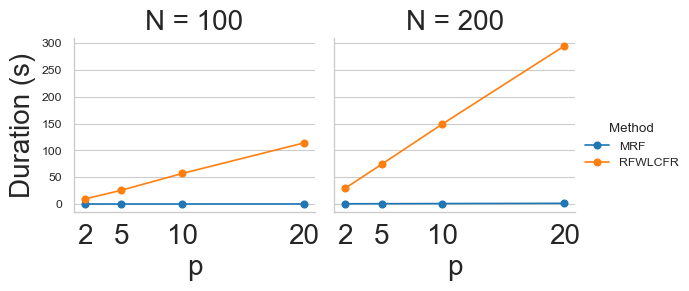

In [14]:
from plot_bench import *
forest_df = make_forest_df(df, dists_ref_method='medoid_2means', Ns=[100,200])
plot_forest_df(forest_df)
plt.savefig("./plots/runtime_phase.pdf")

## MSE CART vs Medoid

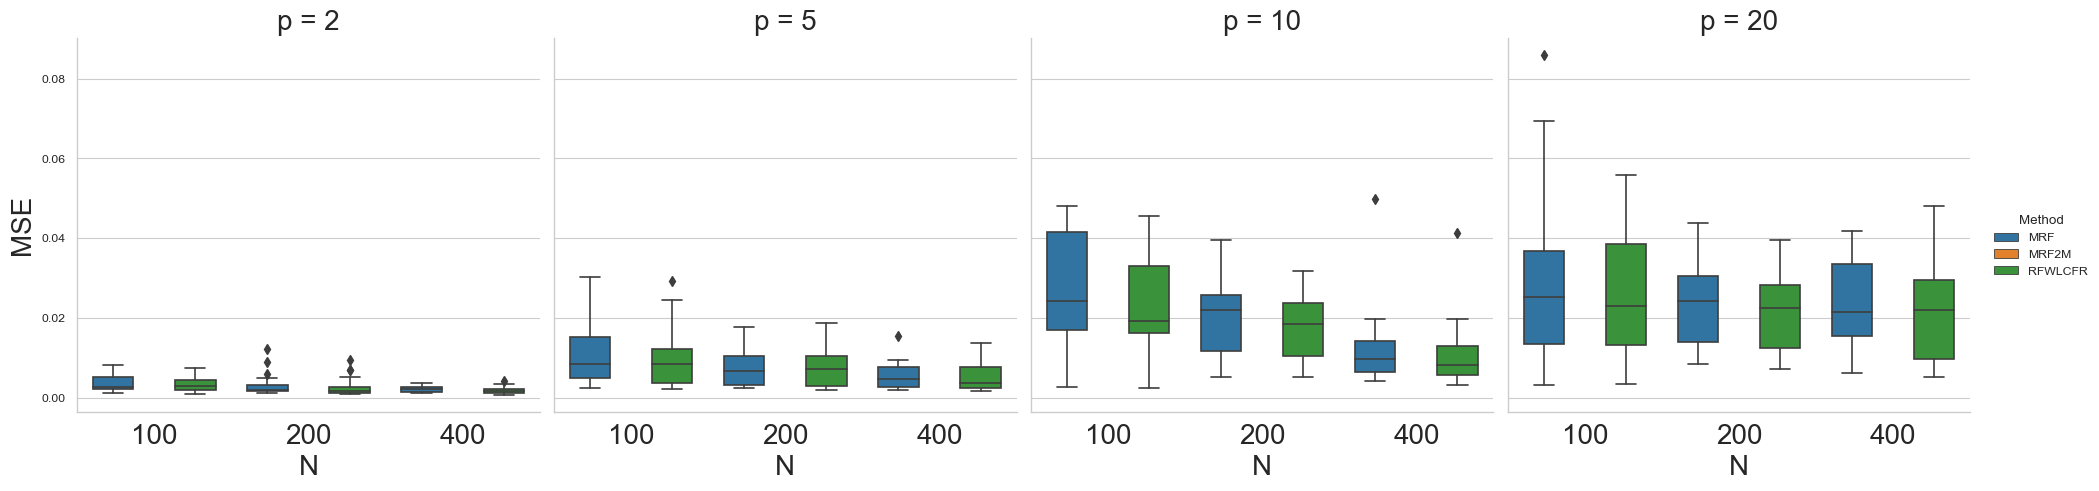

In [9]:
from plot_bench import *
plot_errors(df[df.N != 50])
plt.savefig("./plots/error_phase.pdf")

([<matplotlib.patches.Rectangle object at 0x172111f10>, <matplotlib.patches.Rectangle object at 0x177fb56d0>], ['MRF', 'RFWLCFR'])


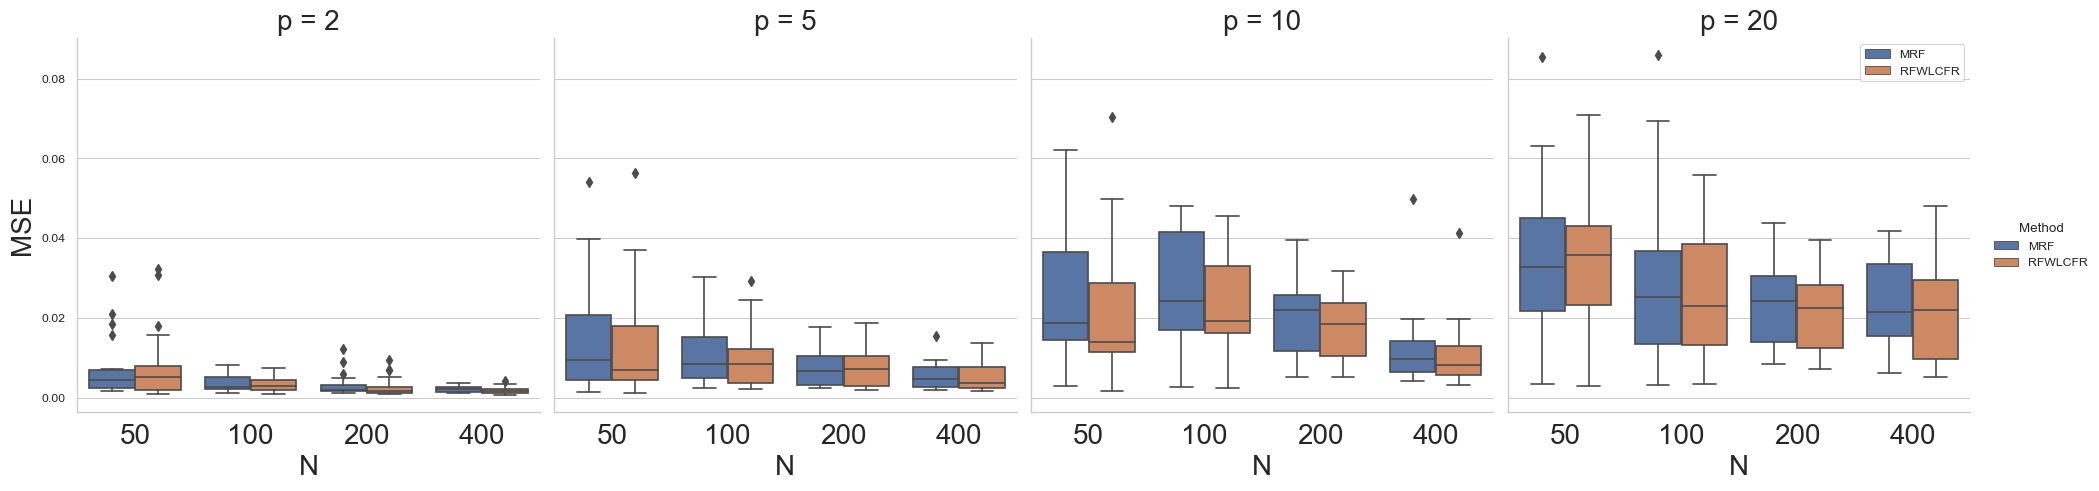

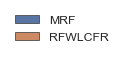

In [12]:
def make_legend(df, expand=[-5,-5,5,5]):
    df = df.copy().rename(columns={ 'err': 'MSE' })
    df['Method'] = df.method.map({'cart_2means': 'RFWLCFR', 'medoid_greedy': 'MRF' })
    sns.set_style("whitegrid")
    sns.set_context("paper", rc={
        "axes.labelsize": 20,
        "xtick.labelsize": 20
    })
    grid = sns.catplot(df,
        x='N', y='MSE',
        col="p",
        hue="Method",
        kind='box', hue_order=['MRF', 'RFWLCFR'])

    legend = plt.legend()
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    legend_squared = legend_ax.legend(
        *grid.axes[0][0].get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncol=1,
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig(
        './plots/legend.pdf',
        bbox_inches='tight',
        bbox_extra_artists=[legend_squared],)


make_legend(df)
